In [27]:
# Use pynapple's bayesian 1D (decode_1d) OR 2D decode (decode_2d)

# as of 9/16/2024 both 1D and 2D work fine
# one issue with 2D is if bin size is too small there is no occupany threshold implemented
# many code blocks here are, or at least were at one point, identical to decocde_wrapper

import os
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import xarray as xr
import seaborn as sns
import pandas as pd
import scipy as sp

from pynwb import NWBHDF5IO
import pynapple as nap

from track_linearization import get_linearized_position

from jlab_nwb import JLabNWBHandler
import analyze_one_nwb_settings.import_settings as analyze1_settings
import beh_core_settings.import_settings as beh_settings
import Utils.epoch_tools as ep_tools
import Beh.Tracking.tracking_preprocessor as tr_pre
import Utils.spike_tools as spk_tools


In [2]:
# Autoreloader Magic Fns
%load_ext autoreload
%autoreload 1
%aimport StateScriptRecData
%aimport Beh.beh_utilities
%aimport jlab_nwb
%aimport Utils.epoch_tools
%aimport analyze_one_nwb_settings.import_settings
%aimport beh_core_settings.import_settings
%aimport Beh.Tracking.tracking_preprocessor
%aimport Utils.spike_tools

In [3]:
# CONSTANTS
# Decode settings
DECODE_DIMS = 2 # 1 for 1D linearized, 2 for 2D using x and y coordinates
BIN_SIZE = 0.01 # default unit in seconds, can change like all pynapple stuff. 0.5 for movement, 0.01 for replay
SPACE_BINS = 20 # how many bins to divide the space into, assumed a perfect square from min max x y, aka SPACE_BINS x SPACE_BINS grid

# Decode unit settings
MAX_FR = 7 # Cells with firing rates above this will be excluded from the decode
MIN_FR = 0.5 # Cells with firing rates below this will be excluded from the decode

# Data constraints to calculate tuning curves on, not decoder on
TRAIN = 'run' # train options: 'run' or 'all'
VEL_THRESH = 4 #tracking_settings['track_moving_threshold_cmPerSecs']
TRAIN_VEL_THRESH = 20 # I found using tracking_settings for this was too low. I wanted a different, higher value to capture times the rat was really running

# MUA event detection settings
MUA_BIN_SIZE = 0.05 # in seconds, size to bin data for MUA burst detection
MUA_BIN_CONCAT = 0.1 # in seconds, if MUA bursts are within this time of each other, they will be concatenated
MUA_MIN_SPIKES = 5 # if a MUA even has fewer ( < ) spikes than this, it will be excluded from the analysis
MUA_SPK_SD_THRESHOLD = 3 # MUA events have to be this many standard deviations above the mean to be considered a burst, purative reactivaiton


In [12]:
# Settings Import
# All hard coded values are loaded or defined in import settings
paths, nwb_settings = analyze1_settings.init_analysis()

# Append beh settings to rec settings
nwb_settings.update(beh_settings.import_beh_core_settings())

tracking_settings = beh_settings.import_tracking_settings()


In [23]:
os.path.join(paths['nwb_path'], paths['nwb_file'])

'/mnt/Fast4TB/DataWorking/Blake/TH405_Day34_training.nwb'

In [25]:
pynwb.validate(os.path.join(paths['nwb_path'], paths['nwb_file']))

TypeError: validate: incorrect type for 'io' (got 'str', expected 'HDMFIO')

In [28]:
with NWBHDF5IO(os.path.join(paths['nwb_path'], paths['nwb_file']), 'r') as io:
            a = io.read()

/home/jmolson/anaconda3/envs/SL_Analysis/lib/python3.12/site-packages/pynwb/file.py:472: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['session_start_time'] = _add_missing_timezone(session_start_time)


ConstructError: (root GroupBuilder {'attributes': {'namespace': 'core', 'neurodata_type': 'NWBFile', 'nwb_version': '2.7.0', 'object_id': '45f39920-c6b1-4548-8e17-1a16d73c913e'}, 'groups': {'acquisition': root/acquisition GroupBuilder {'attributes': {}, 'groups': {'Behavioral Tracking Videos': root/acquisition/Behavioral Tracking Videos GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Behavior video of animal moving in environment.', 'namespace': 'core', 'neurodata_type': 'ImageSeries', 'object_id': 'f9b9d4eb-174c-4895-ad78-70895a99240e'}, 'groups': {}, 'datasets': {'data': root/acquisition/Behavioral Tracking Videos/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'n.a.'}, 'data': <Closed HDF5 dataset>}, 'external_file': root/acquisition/Behavioral Tracking Videos/external_file DatasetBuilder {'attributes': {'starting_frame': array([     0,  15722, 115950], dtype=int32)}, 'data': <StrDataset for Closed HDF5 dataset>}, 'format': root/acquisition/Behavioral Tracking Videos/format DatasetBuilder {'attributes': {}, 'data': 'external'}, 'timestamps': root/acquisition/Behavioral Tracking Videos/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'DIOs': root/acquisition/DIOs GroupBuilder {'attributes': {'namespace': 'core', 'neurodata_type': 'BehavioralTimeSeries', 'object_id': 'ff008a69-2ab9-4e35-9a8f-360bfe8f0ed5'}, 'groups': {'Controller_Din1': root/acquisition/DIOs/Controller_Din1 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din1', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'a69857da-821d-4253-8fa9-bda93b74282b'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din1/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din1/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'Controller_Din2': root/acquisition/DIOs/Controller_Din2 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din2', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'd246faa6-d141-42ff-b663-2b8c0ff6b389'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din2/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din2/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'Controller_Din3': root/acquisition/DIOs/Controller_Din3 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din3', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '0cdc64bc-d78a-45ff-9d86-6a76b599096e'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din3/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din3/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'Controller_Din4': root/acquisition/DIOs/Controller_Din4 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din4', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '8640f969-f3eb-4a42-858e-c551767bf0de'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din4/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din4/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'Controller_Din5': root/acquisition/DIOs/Controller_Din5 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din5', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'a824fc66-6e8f-4ff3-925e-d8b1cc35109a'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din5/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din5/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'Controller_Din6': root/acquisition/DIOs/Controller_Din6 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din6', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '0aa4c44f-62e6-4fcb-8f87-74a5eea885fe'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din6/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din6/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'Controller_Din7': root/acquisition/DIOs/Controller_Din7 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din7', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '4135e100-125b-494a-8166-f235deb2ef47'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din7/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din7/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'Controller_Din8': root/acquisition/DIOs/Controller_Din8 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din8', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '66865198-be9b-4d47-9034-d6a73dab6337'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din8/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din8/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din1': root/acquisition/DIOs/ECU_Din1 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din1', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'cc1e532e-8de2-4832-920c-02af044be97d'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din1/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din1/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din10': root/acquisition/DIOs/ECU_Din10 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din10', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '3eb9ac67-3510-4b39-8190-a181a90a7347'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din10/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din10/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din11': root/acquisition/DIOs/ECU_Din11 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din11', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '465d4d6c-2430-4276-bb92-6c92b7f42316'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din11/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din11/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din12': root/acquisition/DIOs/ECU_Din12 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din12', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '9897ba70-421f-48b2-b2c1-eb4be5b51802'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din12/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din12/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din13': root/acquisition/DIOs/ECU_Din13 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din13', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '01dad55b-4ec5-4daf-9f6b-738e82550e52'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din13/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din13/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din14': root/acquisition/DIOs/ECU_Din14 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din14', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '849269b4-23ec-4928-a2f9-be657fb0db70'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din14/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din14/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din15': root/acquisition/DIOs/ECU_Din15 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din15', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'feb6893d-0656-4b81-8ba3-ed01aaaf7ca3'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din15/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din15/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din16': root/acquisition/DIOs/ECU_Din16 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din16', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'ef324bc7-1a21-430a-906b-8f55d5b7f9c5'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din16/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din16/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din17': root/acquisition/DIOs/ECU_Din17 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din17', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '6128930e-4490-4919-b3b5-a827ef503afe'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din17/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din17/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din18': root/acquisition/DIOs/ECU_Din18 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din18', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '1a56daaf-d597-4134-a7e0-118cd2a368d4'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din18/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din18/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din19': root/acquisition/DIOs/ECU_Din19 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din19', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'f7089edf-8cb8-4365-96e1-4ffd0967f5e2'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din19/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din19/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din2': root/acquisition/DIOs/ECU_Din2 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din2', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '40a839de-6c3b-4f80-9e01-417a4d537f41'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din2/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din2/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din20': root/acquisition/DIOs/ECU_Din20 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din20', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '7f62ec22-cb11-4c11-bf3f-ed8f6b8cea10'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din20/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din20/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din21': root/acquisition/DIOs/ECU_Din21 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din21', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '30c7b5f9-6fe2-4717-bfb7-e45611a98e68'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din21/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din21/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din22': root/acquisition/DIOs/ECU_Din22 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din22', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '233f877b-069a-452d-9d6b-411551a8e30a'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din22/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din22/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din23': root/acquisition/DIOs/ECU_Din23 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din23', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '4b7273fa-bf63-49cd-9b1a-44a3b3260e5a'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din23/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din23/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din24': root/acquisition/DIOs/ECU_Din24 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din24', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '389a7a90-6d24-43d5-a185-89f164d7db8c'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din24/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din24/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din25': root/acquisition/DIOs/ECU_Din25 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din25', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '3860937c-641a-415c-9844-10681f6b2c8b'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din25/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din25/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din26': root/acquisition/DIOs/ECU_Din26 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din26', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '69fb4695-ac93-42e6-b22d-61445f51c19a'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din26/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din26/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din27': root/acquisition/DIOs/ECU_Din27 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din27', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '2dc447ae-c23e-4f49-8fe5-b7bf5fe23f6b'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din27/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din27/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din28': root/acquisition/DIOs/ECU_Din28 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din28', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '3846f015-b9d6-4297-9469-3b9e45c9b9a7'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din28/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din28/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din29': root/acquisition/DIOs/ECU_Din29 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din29', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'eb5284b4-afd5-48a7-a486-aba89faf6ce0'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din29/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din29/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din3': root/acquisition/DIOs/ECU_Din3 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din3', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '2e86ce0d-0a2d-4f2c-b436-db238faea888'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din3/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din3/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din30': root/acquisition/DIOs/ECU_Din30 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din30', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '3b2adcb5-c055-4137-80f2-c1cfee6b57da'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din30/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din30/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din31': root/acquisition/DIOs/ECU_Din31 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din31', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'd7aaca03-5423-4388-b87c-ff84ab6ce294'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din31/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din31/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din32': root/acquisition/DIOs/ECU_Din32 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din32', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '76255456-08c6-4992-81ec-1989893feaf7'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din32/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din32/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din4': root/acquisition/DIOs/ECU_Din4 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din4', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'cd46474e-86d4-48d9-817b-70a2035631d6'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din4/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din4/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din5': root/acquisition/DIOs/ECU_Din5 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din5', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '1995de04-5c64-4a7c-8860-7fd68d32e4f1'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din5/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din5/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din6': root/acquisition/DIOs/ECU_Din6 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din6', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '7eed6586-0103-4253-876e-95c63dedb5bf'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din6/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din6/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din7': root/acquisition/DIOs/ECU_Din7 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din7', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'ae9714fe-d5d2-4d8a-a1ba-514c675f8d22'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din7/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din7/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din8': root/acquisition/DIOs/ECU_Din8 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din8', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'e86e0791-cb3e-43c0-bfc7-c5f118abe796'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din8/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din8/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din9': root/acquisition/DIOs/ECU_Din9 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din9', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'b3bc9382-aa19-4fd1-8150-62bc8d633f06'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din9/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din9/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout1': root/acquisition/DIOs/ECU_Dout1 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout1', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'fb8b7500-9a50-4198-80cb-5c9d5418e850'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout1/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout1/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout10': root/acquisition/DIOs/ECU_Dout10 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout10', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '0eb09e62-b984-4b5d-b3f8-55171a39f8dd'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout10/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout10/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout11': root/acquisition/DIOs/ECU_Dout11 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout11', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '56484918-8324-4867-a3a6-715fdbf221ef'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout11/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout11/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout12': root/acquisition/DIOs/ECU_Dout12 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout12', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '1ea8c68c-a717-4a76-90fa-3a3622404fbf'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout12/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout12/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout13': root/acquisition/DIOs/ECU_Dout13 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout13', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '0fbbf165-0b74-411b-b510-95dc0cfa5e22'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout13/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout13/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout14': root/acquisition/DIOs/ECU_Dout14 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout14', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '1c231ce5-01d1-48aa-a4e6-47808065eb2f'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout14/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout14/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout15': root/acquisition/DIOs/ECU_Dout15 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout15', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '5552a988-c3c7-47f1-a780-0511fc4a94c3'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout15/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout15/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout16': root/acquisition/DIOs/ECU_Dout16 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout16', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'cbbba78e-97d4-4aba-97dd-481fa16f4c5a'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout16/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout16/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout17': root/acquisition/DIOs/ECU_Dout17 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout17', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '5636cbb3-5d49-415d-b599-90ff5140f50c'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout17/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout17/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout18': root/acquisition/DIOs/ECU_Dout18 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout18', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'a44906be-e7ed-4320-b6bd-8c37164b866d'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout18/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout18/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout19': root/acquisition/DIOs/ECU_Dout19 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout19', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '26fff899-535c-4db4-aa6a-c037b5d5d287'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout19/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout19/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout2': root/acquisition/DIOs/ECU_Dout2 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout2', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '51ad64a2-3840-4437-ada2-fccf22e63282'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout2/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout2/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout20': root/acquisition/DIOs/ECU_Dout20 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout20', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '4fc03a16-996c-48e6-bc14-1d8fd407e2d7'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout20/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout20/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout21': root/acquisition/DIOs/ECU_Dout21 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout21', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '7189e098-53cc-4676-896a-5d2035a605b9'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout21/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout21/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout22': root/acquisition/DIOs/ECU_Dout22 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout22', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '5be02826-8078-4cf1-bdb2-82bd864a9887'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout22/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout22/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout23': root/acquisition/DIOs/ECU_Dout23 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout23', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '9332ca98-7ca6-4745-8b8f-c3dd46142036'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout23/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout23/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout24': root/acquisition/DIOs/ECU_Dout24 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout24', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'dbc4accd-ae4e-4450-8e55-2eb00b9ab136'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout24/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout24/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout25': root/acquisition/DIOs/ECU_Dout25 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout25', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '962c8a02-0a6a-4e74-8bc8-216de3be54cb'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout25/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout25/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout26': root/acquisition/DIOs/ECU_Dout26 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout26', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'c5b7925a-22e2-40db-a2d9-d2434e6ebe09'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout26/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout26/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout27': root/acquisition/DIOs/ECU_Dout27 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout27', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '405c90bb-72e2-455b-9e30-3c2c4bc21929'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout27/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout27/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout28': root/acquisition/DIOs/ECU_Dout28 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout28', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '46754160-6c95-4aaa-8872-9b33659c7c29'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout28/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout28/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout29': root/acquisition/DIOs/ECU_Dout29 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout29', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '7bb06807-545e-4aa0-abff-467e77f8405c'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout29/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout29/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout3': root/acquisition/DIOs/ECU_Dout3 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout3', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '04b0db78-740c-46d9-b35c-73e72489bf3d'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout3/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout3/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout30': root/acquisition/DIOs/ECU_Dout30 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout30', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '6229689a-6b84-4490-b566-82bc0b7532c6'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout30/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout30/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout31': root/acquisition/DIOs/ECU_Dout31 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout31', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'b522243d-623a-42ac-9bb5-79585c15da76'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout31/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout31/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout32': root/acquisition/DIOs/ECU_Dout32 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout32', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'ca869a14-0e9a-4512-835b-3a2c47e4d391'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout32/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout32/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout4': root/acquisition/DIOs/ECU_Dout4 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout4', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '55840a72-ac7f-418f-b96b-889747a33101'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout4/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout4/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout5': root/acquisition/DIOs/ECU_Dout5 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout5', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '09848bc0-b7de-4155-9d8a-fa58bb5b27df'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout5/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout5/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout6': root/acquisition/DIOs/ECU_Dout6 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout6', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '42db74c3-ba29-4882-ad20-b6085c28bb7d'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout6/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout6/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout7': root/acquisition/DIOs/ECU_Dout7 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout7', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'c806d6c9-8755-4fde-8bec-e9dde3269606'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout7/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout7/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout8': root/acquisition/DIOs/ECU_Dout8 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout8', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'a075ef37-e8c3-418c-a311-6e2cef7554b2'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout8/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout8/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout9': root/acquisition/DIOs/ECU_Dout9 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout9', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '7dc4076c-390a-458f-9f81-e04691485d4d'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout9/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout9/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}}, 'datasets': {}, 'links': {}}, 'Statescript Logs': root/acquisition/Statescript Logs GroupBuilder {'attributes': {'namespace': 'core', 'neurodata_type': 'BehavioralEvents', 'object_id': '5e2b0075-681e-49ce-a0a5-5f8a99deb4e9'}, 'groups': {'Statescript Log File Names': root/acquisition/Statescript Logs/Statescript Log File Names GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Corresponding file names for logs', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '0d6b0412-2c15-4946-8a98-7495e6902901'}, 'groups': {}, 'datasets': {'data': root/acquisition/Statescript Logs/Statescript Log File Names/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'n.a.'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'starting_time': root/acquisition/Statescript Logs/Statescript Log File Names/starting_time DatasetBuilder {'attributes': {'rate': 1.0, 'unit': 'seconds'}, 'data': 1.0}}, 'links': {}}, 'Statescript Logs': root/acquisition/Statescript Logs/Statescript Logs GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Behavior and programming logs from ECU', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '15c8f391-a7ee-42a1-8dbd-16e9999c01fc'}, 'groups': {}, 'datasets': {'data': root/acquisition/Statescript Logs/Statescript Logs/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'n.a.'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'starting_time': root/acquisition/Statescript Logs/Statescript Logs/starting_time DatasetBuilder {'attributes': {'rate': 1.0, 'unit': 'seconds'}, 'data': 1.0}}, 'links': {}}}, 'datasets': {}, 'links': {}}}, 'datasets': {}, 'links': {}}, 'analysis': root/analysis GroupBuilder {'attributes': {}, 'groups': {}, 'datasets': {}, 'links': {}}, 'general': root/general GroupBuilder {'attributes': {}, 'groups': {'devices': root/general/devices GroupBuilder {'attributes': {}, 'groups': {'AdaptAMaze': root/general/devices/AdaptAMaze GroupBuilder {'attributes': {'description': 'Maze Control System', 'manufacturer': 'JadhavLab (JMOlson)', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'e7d960a6-ff0a-4f96-8722-e85d030d1151'}, 'groups': {}, 'datasets': {}, 'links': {}}, 'ECU': root/general/devices/ECU GroupBuilder {'attributes': {'description': 'Environmental Control Unit from SpikeGadgets - I/O control hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'b51197c7-2507-4801-aca4-9a34f6bcc964'}, 'groups': {}, 'datasets': {}, 'links': {}}, 'MCU': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}, 'datasets': {}, 'links': {}}, 'extracellular_ephys': root/general/extracellular_ephys GroupBuilder {'attributes': {}, 'groups': {'electrodes': root/general/extracellular_ephys/electrodes GroupBuilder {'attributes': {'colnames': array(['location', 'group', 'group_name', 'chID', 'hasLFP'], dtype=object), 'description': 'metadata about extracellular electrodes', 'namespace': 'hdmf-common', 'neurodata_type': 'DynamicTable', 'object_id': '62da43a5-d37e-4cbd-a879-d42f9a195c99'}, 'groups': {}, 'datasets': {'chID': root/general/extracellular_ephys/electrodes/chID DatasetBuilder {'attributes': {'description': 'electrode id string', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'd7b63632-6bba-4c08-8139-55fadfb7ae8a'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'group': root/general/extracellular_ephys/electrodes/group DatasetBuilder {'attributes': {'description': 'a reference to the ElectrodeGroup this electrode is a part of', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'e60394a1-5609-486a-80e2-1d22af860ccd'}, 'data': <hdmf.backends.hdf5.h5_utils.BuilderH5ReferenceDataset object at 0x7f26f5f46d20>}, 'group_name': root/general/extracellular_ephys/electrodes/group_name DatasetBuilder {'attributes': {'description': 'the name of the ElectrodeGroup this electrode is a part of', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'a24baa7d-1a9b-4aaf-8b92-debf899854c7'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'hasLFP': root/general/extracellular_ephys/electrodes/hasLFP DatasetBuilder {'attributes': {'description': 'boolean indicator if lfp was collected', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '2649ea84-fea7-439f-af5c-aa22ea5692bc'}, 'data': <Closed HDF5 dataset>}, 'id': root/general/extracellular_ephys/electrodes/id DatasetBuilder {'attributes': {'namespace': 'hdmf-common', 'neurodata_type': 'ElementIdentifiers', 'object_id': 'ed498189-7380-43a3-a273-d05bdbc6acc3'}, 'data': <Closed HDF5 dataset>}, 'location': root/general/extracellular_ephys/electrodes/location DatasetBuilder {'attributes': {'description': 'the location of channel within the subject e.g. brain region', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'e6371b56-d015-4695-87b9-ad55a5ecf1f5'}, 'data': <StrDataset for Closed HDF5 dataset>}}, 'links': {}}, 'nTrode1': root/general/extracellular_ephys/nTrode1 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 1', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'f0c09667-b68f-43ef-98ba-0a1b9dbc48f9'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode1/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode18': root/general/extracellular_ephys/nTrode18 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 18', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '9bed0c27-2ad8-4bd4-b622-5abbbc71b76a'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode18/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode19': root/general/extracellular_ephys/nTrode19 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 19', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '43223c7d-516f-4c06-9ccb-c01d1b62a1e5'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode19/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode20': root/general/extracellular_ephys/nTrode20 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 20', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '5894f0c9-020e-49a3-8307-c89f9ceccc75'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode20/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode21': root/general/extracellular_ephys/nTrode21 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 21', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '6752e2c5-a5e6-430d-849e-02520c3fbfb1'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode21/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode22': root/general/extracellular_ephys/nTrode22 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 22', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'ed469fe6-5723-423c-b39e-6995b2499653'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode22/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode23': root/general/extracellular_ephys/nTrode23 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 23', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '6ce3c6fb-44a8-4942-8c45-6af132dc2590'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode23/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode24': root/general/extracellular_ephys/nTrode24 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 24', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '8d817198-8382-458c-ad75-726ca6108187'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode24/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode25': root/general/extracellular_ephys/nTrode25 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 25', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '0036b72b-c33f-43f0-9b2a-b3593d57afb1'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode25/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode26': root/general/extracellular_ephys/nTrode26 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 26', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '9c4447a3-4e10-4aef-a394-f9db8e8711cc'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode26/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode27': root/general/extracellular_ephys/nTrode27 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 27', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '8fd2b31f-0282-4368-b5e6-2dee34bf677e'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode27/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode28': root/general/extracellular_ephys/nTrode28 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 28', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '4a82b951-0002-41ff-a85e-d56d1bfc8c18'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode28/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode29': root/general/extracellular_ephys/nTrode29 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 29', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '342abf77-d0a3-45b7-853d-7bf60935e591'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode29/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode30': root/general/extracellular_ephys/nTrode30 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 30', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '249a30d8-95e8-40e4-ad56-fe2715d0d6ba'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode30/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode31': root/general/extracellular_ephys/nTrode31 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 31', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '6ff3b3be-b949-4e43-b824-93deedcd7cce'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode31/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode32': root/general/extracellular_ephys/nTrode32 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 32', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'ac9dfac4-e44a-4011-bc43-60fb31bb187f'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode32/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode33': root/general/extracellular_ephys/nTrode33 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 33', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'c96f24e6-7ffe-4dc0-98ee-b91699b8b12f'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode33/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode34': root/general/extracellular_ephys/nTrode34 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 34', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'f586dadf-2d95-49ed-ba6a-7b2a136758d4'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode34/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode35': root/general/extracellular_ephys/nTrode35 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 35', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '4062d71d-0f48-423a-a961-76097421bdcc'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode35/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode36': root/general/extracellular_ephys/nTrode36 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 36', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'c92ae435-2217-48fe-9892-7064b1c051eb'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode36/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode37': root/general/extracellular_ephys/nTrode37 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 37', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '2300ccd8-fce2-43e9-aec6-8f12da3fa2f4'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode37/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode38': root/general/extracellular_ephys/nTrode38 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 38', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'e1fe9cf5-ddee-4f81-a6f7-2438aed1e47b'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode38/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode39': root/general/extracellular_ephys/nTrode39 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 39', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '23d8b320-411c-454f-afa8-d1732a9e5a2d'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode39/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode40': root/general/extracellular_ephys/nTrode40 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 40', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '264358ab-40f2-4cc7-8032-a749e1d7b461'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode40/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode41': root/general/extracellular_ephys/nTrode41 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 41', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '8ebb6530-2e9b-4bf4-b1b9-252b6605b96a'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode41/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode42': root/general/extracellular_ephys/nTrode42 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 42', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '1327dffc-ffee-4b53-a155-41b2f1d50b32'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode42/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode43': root/general/extracellular_ephys/nTrode43 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 43', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'ec01b5da-368d-4f2a-8001-0d8ef0aad8a0'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode43/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode44': root/general/extracellular_ephys/nTrode44 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 44', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '71903679-7f0c-4959-9f0d-ef32be97ba38'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode44/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode45': root/general/extracellular_ephys/nTrode45 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 45', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '694e537c-f6b9-4518-a159-cbd55883e9d5'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode45/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode46': root/general/extracellular_ephys/nTrode46 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 46', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '69faa55b-1fe5-4a0e-82c2-3151b98fb2a7'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode46/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode47': root/general/extracellular_ephys/nTrode47 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 47', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '98c22df6-96b6-4655-9292-bc7e59d52d87'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode47/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode48': root/general/extracellular_ephys/nTrode48 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 48', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'd8ecd211-40bf-447c-99b0-2a905a81551c'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode48/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode49': root/general/extracellular_ephys/nTrode49 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 49', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'd13d7604-8f8d-4593-86e6-16785a7a1030'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode49/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode50': root/general/extracellular_ephys/nTrode50 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 50', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '5e543567-6c8e-4cba-940c-1894053d2aac'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode50/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode51': root/general/extracellular_ephys/nTrode51 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 51', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '8be86e7a-97a6-4627-b779-569f6ed43291'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode51/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode52': root/general/extracellular_ephys/nTrode52 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 52', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'd3092f56-f517-4aea-b169-a99c72b4dc5c'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode52/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode53': root/general/extracellular_ephys/nTrode53 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 53', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '19fcd1b0-6c45-4bc7-aebf-84ccdcfb0629'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode53/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode54': root/general/extracellular_ephys/nTrode54 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 54', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'bb71e9f6-3b6c-49fa-a1fa-d3866175b7b7'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode54/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode55': root/general/extracellular_ephys/nTrode55 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 55', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '9f19d56e-ca8b-48fa-9325-54305c08b1c4'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode55/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode56': root/general/extracellular_ephys/nTrode56 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 56', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'd089dafb-7878-406f-8f7f-a1537cc88bb0'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode56/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode57': root/general/extracellular_ephys/nTrode57 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 57', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '277c158c-48c1-40f5-ad12-697fbe83c430'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode57/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode58': root/general/extracellular_ephys/nTrode58 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 58', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '871af58a-b2b8-43f4-b8e0-eaf859a782d9'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode58/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode59': root/general/extracellular_ephys/nTrode59 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 59', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'a7abc655-60d1-4fc8-a1d7-25a7a0ff60bc'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode59/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode60': root/general/extracellular_ephys/nTrode60 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 60', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '7abd1838-b8aa-49a4-9588-ccc7f130e0c7'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode60/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode61': root/general/extracellular_ephys/nTrode61 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 61', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'e2df2396-8ce8-4f18-a22d-2959c0a79dc1'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode61/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode62': root/general/extracellular_ephys/nTrode62 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 62', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'c8bac143-88dc-4361-bf36-21b55827ac94'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode62/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode63': root/general/extracellular_ephys/nTrode63 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 63', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '36cdd1a4-981a-41b6-861f-640ba40771c1'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode63/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode64': root/general/extracellular_ephys/nTrode64 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 64', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '7412c10f-913b-4243-b8e2-180e4e9cae1e'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode64/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}}, 'datasets': {}, 'links': {}}, 'subject': root/general/subject GroupBuilder {'attributes': {'namespace': 'core', 'neurodata_type': 'Subject', 'object_id': 'bf1d1534-d1d9-470b-933b-7730f3b497c6'}, 'groups': {}, 'datasets': {'description': root/general/subject/description DatasetBuilder {'attributes': {}, 'data': 'Long Evans Rat'}, 'genotype': root/general/subject/genotype DatasetBuilder {'attributes': {}, 'data': 'Wild Type'}, 'sex': root/general/subject/sex DatasetBuilder {'attributes': {}, 'data': 'M'}, 'species': root/general/subject/species DatasetBuilder {'attributes': {}, 'data': 'Ratticus norvegicus'}, 'subject_id': root/general/subject/subject_id DatasetBuilder {'attributes': {}, 'data': 'TH405'}, 'weight': root/general/subject/weight DatasetBuilder {'attributes': {}, 'data': '467g'}}, 'links': {}}}, 'datasets': {'data_collection': root/general/data_collection DatasetBuilder {'attributes': {}, 'data': 'behavioral_events:\n- description: Reward Well 1\n  id: ECU_Din1\n- description: Reward Well 2\n  id: ECU_Din2\n- description: Reward Well 3\n  id: ECU_Din3\n- description: Reward Well 4\n  id: ECU_Din4\n- description: Reward Well 5\n  id: ECU_Din5\n- description: Reward Well 6\n  id: ECU_Din6\n- description: Reward Well 7\n  id: ECU_Din7\n- description: Reward Well 8\n  id: ECU_Din8\n- description: Reward Pump 1\n  id: ECU_Dout1\n- description: Reward Pump 2\n  id: ECU_Dout2\n- description: Reward Pump 3\n  id: ECU_Dout3\n- description: Reward Pump 4\n  id: ECU_Dout4\n- description: Reward Pump 5\n  id: ECU_Dout5\n- description: Reward Pump 6\n  id: ECU_Dout6\n- description: Reward Pump 7\n  id: ECU_Dout7\n- description: Reward Pump 8\n  id: ECU_Dout8\n- description: Barrier 1\n  id: ECU_Dout17\n- description: Barrier 2\n  id: ECU_Dout18\n- description: Barrier 3\n  id: ECU_Dout19\n- description: Barrier 4\n  id: ECU_Dout20\n- description: Barrier 5\n  id: ECU_Dout21\n- description: Barrier 6\n  id: ECU_Dout22\n- description: Barrier 7\n  id: ECU_Dout23\n- description: Barrier 8\n  id: ECU_Dout24\ncameras:\n- camera_name: Track\n  id: 0\n  lens: Theia SL183M\n  manufacturer: Allied Vision\n  meters_per_pixel: 0.0025\n  model: Mako G-158C\ndata_acq_device:\n- description: Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals,\n    and Coordination across hardware\n  manufacturer: SpikeGadgets\n  system: MCU\n- description: Environmental Control Unit from SpikeGadgets - I/O control hardware\n  manufacturer: SpikeGadgets\n  system: ECU\n- description: Maze Control System\n  manufacturer: JadhavLab (JMOlson)\n  system: AdaptAMaze\nepochs:\n- id: preSleep\n  index: 1\n  led_configuration:\n  - double\n  led_list:\n  - redLED\n  - greenLED\n  led_positions:\n  - front\n  - back\n  task_name: Sleep\n- id: track\n  index: 2\n  led_configuration:\n  - double\n  led_list:\n  - redLED\n  - greenLED\n  led_positions:\n  - front\n  - back\n  task_name: Transitive inference training\n- id: postSleep\n  index: 3\n  led_configuration:\n  - double\n  led_list:\n  - redLED\n  - greenLED\n  led_positions:\n  - front\n  - back\n  task_name: Sleep\nexperiment_description: Inference\nexperimenter_name: Blake Porter\nimplant_locations:\n- location: CA1_R\n  nTrodes:\n  - 1\n  - 54\n  - 55\n  - 56\n  - 57\n  - 58\n  - 59\n  - 60\n  - 61\n  - 62\n  - 63\n  - 64\n- location: CA1_L\n  nTrodes:\n  - 18\n  - 19\n  - 20\n  - 21\n  - 22\n  - 23\n  - 24\n  - 25\n  - 26\n  - 27\n  - 28\n  - 29\n- location: PFC_L,\n  nTrodes:\n  - 42\n  - 43\n  - 44\n  - 45\n  - 46\n  - 47\n  - 48\n  - 49\n  - 50\n  - 51\n  - 52\n  - 53\n- location: PFC_R\n  nTrodes:\n  - 30\n  - 31\n  - 32\n  - 33\n  - 34\n  - 35\n  - 36\n  - 37\n  - 38\n  - 39\n  - 40\n  - 41\n- location: VTA_L\n  nTrodes:\n  - 2\n  - 3\n  - 4\n  - 5\n  - 6\n  - 7\n  - 8\n  - 9\n- location: VTA_R\n  nTrodes:\n  - 10\n  - 11\n  - 12\n  - 13\n  - 14\n  - 15\n  - 16\n  - 17\ninstitution: Brandeis University\nlab: Shantanu Jadhav\nsession_description: Sleep - Track - Sleep\nsession_id: TH405_D34\nsubject:\n  description: Long Evans Rat\n  genotype: Wild Type\n  sex: M\n  species: Ratticus norvegicus\n  subject_id: TH405\n  weight: 467g\ntasks:\n- camera_id:\n  - 0\n  task_description: The animal sleeps in a small empty box.\n  task_epochs:\n  - 1\n  - 3\n  task_name: Sleep\n- camera_id:\n  - 0\n  task_description: Shuttle task between home and 4 destinations.\n  task_epochs:\n  - 2\n  task_name: Transitive inference training\nunits:\n  analog: unspecified\n  behavioral_events: unspecified\n'}, 'experiment_description': root/general/experiment_description DatasetBuilder {'attributes': {}, 'data': 'Inference'}, 'experimenter': root/general/experimenter DatasetBuilder {'attributes': {}, 'data': <StrDataset for Closed HDF5 dataset>}, 'institution': root/general/institution DatasetBuilder {'attributes': {}, 'data': 'Brandeis University'}, 'lab': root/general/lab DatasetBuilder {'attributes': {}, 'data': 'Shantanu Jadhav'}}, 'links': {}}, 'intervals': root/intervals GroupBuilder {'attributes': {}, 'groups': {'epochs': root/intervals/epochs GroupBuilder {'attributes': {'colnames': array(['start_time', 'stop_time', 'sesID', 'epoch_info',
       'epoch_info_columns', 'tags'], dtype=object), 'description': 'experimental epochs', 'namespace': 'core', 'neurodata_type': 'TimeIntervals', 'object_id': 'a02337e2-62bd-4137-9edd-26dd00354618'}, 'groups': {}, 'datasets': {'epoch_info': root/intervals/epochs/epoch_info DatasetBuilder {'attributes': {'description': 'all epoch info from file naming convention', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '275cdf51-8ec1-4cf5-990b-8f2a90209b96'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'epoch_info_columns': root/intervals/epochs/epoch_info_columns DatasetBuilder {'attributes': {'description': 'all session info columns from file naming convention', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'b13154fb-32f5-445d-b83e-2e998bd51b40'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'id': root/intervals/epochs/id DatasetBuilder {'attributes': {'namespace': 'hdmf-common', 'neurodata_type': 'ElementIdentifiers', 'object_id': '18220a53-374e-4b6c-b46a-999ce42be733'}, 'data': <Closed HDF5 dataset>}, 'sesID': root/intervals/epochs/sesID DatasetBuilder {'attributes': {'description': 'within day file unique session ID', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '22c496ac-c001-4d6f-a6a2-d934ff5b34de'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'start_time': root/intervals/epochs/start_time DatasetBuilder {'attributes': {'description': 'Start time of epoch, in seconds', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '9e4b030b-2398-448c-bd5b-c30b26069ecc'}, 'data': <Closed HDF5 dataset>}, 'stop_time': root/intervals/epochs/stop_time DatasetBuilder {'attributes': {'description': 'Stop time of epoch, in seconds', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '1590a74a-5e12-47d4-b857-02f70de2e987'}, 'data': <Closed HDF5 dataset>}, 'tags': root/intervals/epochs/tags DatasetBuilder {'attributes': {'description': 'user-defined tags', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '325e1653-6629-41d2-b6c4-1c620403fa8b'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'tags_index': root/intervals/epochs/tags_index DatasetBuilder {'attributes': {'description': "Index for VectorData 'tags'", 'namespace': 'hdmf-common', 'neurodata_type': 'VectorIndex', 'object_id': '91a74157-ab34-4fa9-b957-1e45c7d126aa', 'target': root/intervals/epochs/tags DatasetBuilder {'attributes': {'description': 'user-defined tags', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '325e1653-6629-41d2-b6c4-1c620403fa8b'}, 'data': <StrDataset for Closed HDF5 dataset>}}, 'data': <Closed HDF5 dataset>}}, 'links': {}}}, 'datasets': {}, 'links': {}}, 'processing': root/processing GroupBuilder {'attributes': {}, 'groups': {'behavior': root/processing/behavior GroupBuilder {'attributes': {'description': 'Processed behavioral data', 'namespace': 'core', 'neurodata_type': 'ProcessingModule', 'object_id': '3deb5ffa-ef00-4ffd-8916-87024ac49770'}, 'groups': {'PoseEstimation': root/processing/behavior/PoseEstimation GroupBuilder {'attributes': {'namespace': 'ndx-pose', 'neurodata_type': 'PoseEstimation', 'object_id': '3c62fad2-d7a1-40a6-a9b2-463ff3a83b3f'}, 'groups': {'baseTail': root/processing/behavior/PoseEstimation/baseTail GroupBuilder {'attributes': {'comments': 'no comments', 'description': '', 'namespace': 'ndx-pose', 'neurodata_type': 'PoseEstimationSeries', 'object_id': '3fe00a95-e559-4919-a5bf-90b507c526e1'}, 'groups': {}, 'datasets': {'confidence': root/processing/behavior/PoseEstimation/baseTail/confidence DatasetBuilder {'attributes': {'definition': 'Softmax output of the deep neural network.'}, 'data': <Closed HDF5 dataset>}, 'data': root/processing/behavior/PoseEstimation/baseTail/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'pixels'}, 'data': <Closed HDF5 dataset>}, 'reference_frame': root/processing/behavior/PoseEstimation/baseTail/reference_frame DatasetBuilder {'attributes': {}, 'data': '(0, 0) corresponds to bottom left of the image'}, 'timestamps': root/processing/behavior/PoseEstimation/baseTail/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'greenLED': root/processing/behavior/PoseEstimation/greenLED GroupBuilder {'attributes': {'comments': 'no comments', 'description': '', 'namespace': 'ndx-pose', 'neurodata_type': 'PoseEstimationSeries', 'object_id': '210a574a-ff7f-4f7d-8d32-bce4a7d33299'}, 'groups': {}, 'datasets': {'confidence': root/processing/behavior/PoseEstimation/greenLED/confidence DatasetBuilder {'attributes': {'definition': 'Softmax output of the deep neural network.'}, 'data': <Closed HDF5 dataset>}, 'data': root/processing/behavior/PoseEstimation/greenLED/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'pixels'}, 'data': <Closed HDF5 dataset>}, 'reference_frame': root/processing/behavior/PoseEstimation/greenLED/reference_frame DatasetBuilder {'attributes': {}, 'data': '(0, 0) corresponds to bottom left of the image'}, 'timestamps': root/processing/behavior/PoseEstimation/greenLED/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'haunch': root/processing/behavior/PoseEstimation/haunch GroupBuilder {'attributes': {'comments': 'no comments', 'description': '', 'namespace': 'ndx-pose', 'neurodata_type': 'PoseEstimationSeries', 'object_id': 'f5ba2b0b-15bc-4c0b-b3f9-a11583fc2361'}, 'groups': {}, 'datasets': {'confidence': root/processing/behavior/PoseEstimation/haunch/confidence DatasetBuilder {'attributes': {'definition': 'Softmax output of the deep neural network.'}, 'data': <Closed HDF5 dataset>}, 'data': root/processing/behavior/PoseEstimation/haunch/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'pixels'}, 'data': <Closed HDF5 dataset>}, 'reference_frame': root/processing/behavior/PoseEstimation/haunch/reference_frame DatasetBuilder {'attributes': {}, 'data': '(0, 0) corresponds to bottom left of the image'}, 'timestamps': root/processing/behavior/PoseEstimation/haunch/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'redLED': root/processing/behavior/PoseEstimation/redLED GroupBuilder {'attributes': {'comments': 'no comments', 'description': '', 'namespace': 'ndx-pose', 'neurodata_type': 'PoseEstimationSeries', 'object_id': '5f59e762-7f07-4f68-b29b-618d4096f90d'}, 'groups': {}, 'datasets': {'confidence': root/processing/behavior/PoseEstimation/redLED/confidence DatasetBuilder {'attributes': {'definition': 'Softmax output of the deep neural network.'}, 'data': <Closed HDF5 dataset>}, 'data': root/processing/behavior/PoseEstimation/redLED/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'pixels'}, 'data': <Closed HDF5 dataset>}, 'reference_frame': root/processing/behavior/PoseEstimation/redLED/reference_frame DatasetBuilder {'attributes': {}, 'data': '(0, 0) corresponds to bottom left of the image'}, 'timestamps': root/processing/behavior/PoseEstimation/redLED/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'shoulder': root/processing/behavior/PoseEstimation/shoulder GroupBuilder {'attributes': {'comments': 'no comments', 'description': '', 'namespace': 'ndx-pose', 'neurodata_type': 'PoseEstimationSeries', 'object_id': '1171c52f-f13f-4f18-9e24-3207e389832e'}, 'groups': {}, 'datasets': {'confidence': root/processing/behavior/PoseEstimation/shoulder/confidence DatasetBuilder {'attributes': {'definition': 'Softmax output of the deep neural network.'}, 'data': <Closed HDF5 dataset>}, 'data': root/processing/behavior/PoseEstimation/shoulder/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'pixels'}, 'data': <Closed HDF5 dataset>}, 'reference_frame': root/processing/behavior/PoseEstimation/shoulder/reference_frame DatasetBuilder {'attributes': {}, 'data': '(0, 0) corresponds to bottom left of the image'}, 'timestamps': root/processing/behavior/PoseEstimation/shoulder/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}}, 'datasets': {'description': root/processing/behavior/PoseEstimation/description DatasetBuilder {'attributes': {}, 'data': 'Estimated body part positions using DeepLabCut.'}, 'nodes': root/processing/behavior/PoseEstimation/nodes DatasetBuilder {'attributes': {}, 'data': <StrDataset for Closed HDF5 dataset>}}, 'links': {}}}, 'datasets': {}, 'links': {}}, 'ecephys': root/processing/ecephys GroupBuilder {'attributes': {'description': 'Processed extracellular electrophysiology data', 'namespace': 'core', 'neurodata_type': 'ProcessingModule', 'object_id': '92eba85f-1cf2-4947-80f4-edda964830b7'}, 'groups': {'LFP': root/processing/ecephys/LFP GroupBuilder {'attributes': {'namespace': 'core', 'neurodata_type': 'LFP', 'object_id': 'f995d31a-fb08-406f-81d1-2e0e1d32b5fc'}, 'groups': {'ElectricalSeries': root/processing/ecephys/LFP/ElectricalSeries GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'no description', 'namespace': 'core', 'neurodata_type': 'ElectricalSeries', 'object_id': '87d492b2-238c-4958-abdf-80a7f36e124b'}, 'groups': {}, 'datasets': {'data': root/processing/ecephys/LFP/ElectricalSeries/data DatasetBuilder {'attributes': {'conversion': 1e-06, 'offset': 0.0, 'resolution': -1.0, 'unit': 'volts'}, 'data': <Closed HDF5 dataset>}, 'electrodes': root/processing/ecephys/LFP/ElectricalSeries/electrodes DatasetBuilder {'attributes': {'description': 'lfp electrodes', 'namespace': 'hdmf-common', 'neurodata_type': 'DynamicTableRegion', 'object_id': '5eae69bd-72ed-4a14-9fd2-6d68b56a0f4e', 'table': root/general/extracellular_ephys/electrodes GroupBuilder {'attributes': {'colnames': array(['location', 'group', 'group_name', 'chID', 'hasLFP'], dtype=object), 'description': 'metadata about extracellular electrodes', 'namespace': 'hdmf-common', 'neurodata_type': 'DynamicTable', 'object_id': '62da43a5-d37e-4cbd-a879-d42f9a195c99'}, 'groups': {}, 'datasets': {'chID': root/general/extracellular_ephys/electrodes/chID DatasetBuilder {'attributes': {'description': 'electrode id string', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'd7b63632-6bba-4c08-8139-55fadfb7ae8a'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'group': root/general/extracellular_ephys/electrodes/group DatasetBuilder {'attributes': {'description': 'a reference to the ElectrodeGroup this electrode is a part of', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'e60394a1-5609-486a-80e2-1d22af860ccd'}, 'data': <hdmf.backends.hdf5.h5_utils.BuilderH5ReferenceDataset object at 0x7f26f5f46d20>}, 'group_name': root/general/extracellular_ephys/electrodes/group_name DatasetBuilder {'attributes': {'description': 'the name of the ElectrodeGroup this electrode is a part of', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'a24baa7d-1a9b-4aaf-8b92-debf899854c7'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'hasLFP': root/general/extracellular_ephys/electrodes/hasLFP DatasetBuilder {'attributes': {'description': 'boolean indicator if lfp was collected', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '2649ea84-fea7-439f-af5c-aa22ea5692bc'}, 'data': <Closed HDF5 dataset>}, 'id': root/general/extracellular_ephys/electrodes/id DatasetBuilder {'attributes': {'namespace': 'hdmf-common', 'neurodata_type': 'ElementIdentifiers', 'object_id': 'ed498189-7380-43a3-a273-d05bdbc6acc3'}, 'data': <Closed HDF5 dataset>}, 'location': root/general/extracellular_ephys/electrodes/location DatasetBuilder {'attributes': {'description': 'the location of channel within the subject e.g. brain region', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'e6371b56-d015-4695-87b9-ad55a5ecf1f5'}, 'data': <StrDataset for Closed HDF5 dataset>}}, 'links': {}}}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/processing/ecephys/LFP/ElectricalSeries/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}}, 'datasets': {}, 'links': {}}}, 'datasets': {}, 'links': {}}}, 'datasets': {}, 'links': {}}, 'stimulus': root/stimulus GroupBuilder {'attributes': {}, 'groups': {'presentation': root/stimulus/presentation GroupBuilder {'attributes': {}, 'groups': {}, 'datasets': {}, 'links': {}}, 'templates': root/stimulus/templates GroupBuilder {'attributes': {}, 'groups': {}, 'datasets': {}, 'links': {}}}, 'datasets': {}, 'links': {}}, 'units': root/units GroupBuilder {'attributes': {'colnames': array(['nTrode', 'unitInd', 'region', 'nWaveforms', 'waveformFWHM',
       'waveformPeakMinusTrough', 'spike_times'], dtype=object), 'description': 'Autogenerated by NWBFile', 'namespace': 'core', 'neurodata_type': 'Units', 'object_id': '4c9a21b9-743f-4ae4-8990-383e1036bd91'}, 'groups': {}, 'datasets': {'id': root/units/id DatasetBuilder {'attributes': {'namespace': 'hdmf-common', 'neurodata_type': 'ElementIdentifiers', 'object_id': '91d11073-d79e-4e99-9ea3-b17a87d1dc3a'}, 'data': <Closed HDF5 dataset>}, 'nTrode': root/units/nTrode DatasetBuilder {'attributes': {'description': 'electrode id integer', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'f19de290-627e-48d0-b362-ac36645c95e4'}, 'data': <Closed HDF5 dataset>}, 'nWaveforms': root/units/nWaveforms DatasetBuilder {'attributes': {'description': 'integer number of waveforms for each unit', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'f5c69532-97c7-43ed-b5f2-d6b4848f5617'}, 'data': <Closed HDF5 dataset>}, 'region': root/units/region DatasetBuilder {'attributes': {'description': 'string region where the ntrode is located', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '8370df66-d47e-42d4-a3a3-1d011b2bfa9e'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'spike_times': root/units/spike_times DatasetBuilder {'attributes': {'description': 'the spike times for each unit', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '8682796a-e025-429f-a77a-cf48f971cab6'}, 'data': <Closed HDF5 dataset>}, 'spike_times_index': root/units/spike_times_index DatasetBuilder {'attributes': {'description': "Index for VectorData 'spike_times'", 'namespace': 'hdmf-common', 'neurodata_type': 'VectorIndex', 'object_id': '1b4e53c0-84ab-4d7c-a657-f2a7bdde4b59', 'target': root/units/spike_times DatasetBuilder {'attributes': {'description': 'the spike times for each unit', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '8682796a-e025-429f-a77a-cf48f971cab6'}, 'data': <Closed HDF5 dataset>}}, 'data': <Closed HDF5 dataset>}, 'unitInd': root/units/unitInd DatasetBuilder {'attributes': {'description': 'integer id each unit within each nTrode', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'a8eb251e-5718-4fb6-bc15-f030f68b08de'}, 'data': <Closed HDF5 dataset>}, 'waveformFWHM': root/units/waveformFWHM DatasetBuilder {'attributes': {'description': 'float full width half max of the waveform', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '3a30dca3-8c75-45cb-8bb2-aec99079378a'}, 'data': <Closed HDF5 dataset>}, 'waveformPeakMinusTrough': root/units/waveformPeakMinusTrough DatasetBuilder {'attributes': {'description': 'float peak minus trough of the waveform', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '960ee516-8ff6-49c8-8510-3f9aa1220864'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}}, 'datasets': {'file_create_date': root/file_create_date DatasetBuilder {'attributes': {}, 'data': <Closed HDF5 dataset>}, 'identifier': root/identifier DatasetBuilder {'attributes': {}, 'data': 'TH405_D34'}, 'session_description': root/session_description DatasetBuilder {'attributes': {}, 'data': 'Sleep - Track - Sleep'}, 'session_start_time': root/session_start_time DatasetBuilder {'attributes': {}, 'data': '2023-04-04T17:15:49.581000'}, 'timestamps_reference_time': root/timestamps_reference_time DatasetBuilder {'attributes': {}, 'data': '2023-04-04T17:15:49.581000'}}, 'links': {}}, "Could not construct NWBFile object due to: 'timestamps_reference_time' must be a timezone-aware datetime object.")

In [17]:
# Open NWB
day_rec = JLabNWBHandler(nwb_name=paths['nwb_file'],nwb_path=paths['nwb_path'])

# General Loading
exp_metadata = day_rec.get_exp_metadata()
epochs_intSet, epochs_df = ep_tools.import_epochs(
    day_rec, nwb_settings) 

visits_file = os.path.join(paths['beh_path'], paths['nwb_file_stem']
                         + nwb_settings['fname_visits_df'])
visits_df = pd.read_pickle(visits_file)

traj_df = pd.read_pickle(os.path.join(paths['beh_path'], paths['nwb_file_stem']
                                      + nwb_settings['fname_trajectories_df']))

/home/jmolson/anaconda3/envs/SL_Analysis/lib/python3.12/site-packages/pynwb/file.py:472: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['session_start_time'] = _add_missing_timezone(session_start_time)


ConstructError: (root GroupBuilder {'attributes': {'namespace': 'core', 'neurodata_type': 'NWBFile', 'nwb_version': '2.7.0', 'object_id': '45f39920-c6b1-4548-8e17-1a16d73c913e'}, 'groups': {'acquisition': root/acquisition GroupBuilder {'attributes': {}, 'groups': {'Behavioral Tracking Videos': root/acquisition/Behavioral Tracking Videos GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Behavior video of animal moving in environment.', 'namespace': 'core', 'neurodata_type': 'ImageSeries', 'object_id': 'f9b9d4eb-174c-4895-ad78-70895a99240e'}, 'groups': {}, 'datasets': {'data': root/acquisition/Behavioral Tracking Videos/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'n.a.'}, 'data': <Closed HDF5 dataset>}, 'external_file': root/acquisition/Behavioral Tracking Videos/external_file DatasetBuilder {'attributes': {'starting_frame': array([     0,  15722, 115950], dtype=int32)}, 'data': <StrDataset for Closed HDF5 dataset>}, 'format': root/acquisition/Behavioral Tracking Videos/format DatasetBuilder {'attributes': {}, 'data': 'external'}, 'timestamps': root/acquisition/Behavioral Tracking Videos/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'DIOs': root/acquisition/DIOs GroupBuilder {'attributes': {'namespace': 'core', 'neurodata_type': 'BehavioralTimeSeries', 'object_id': 'ff008a69-2ab9-4e35-9a8f-360bfe8f0ed5'}, 'groups': {'Controller_Din1': root/acquisition/DIOs/Controller_Din1 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din1', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'a69857da-821d-4253-8fa9-bda93b74282b'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din1/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din1/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'Controller_Din2': root/acquisition/DIOs/Controller_Din2 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din2', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'd246faa6-d141-42ff-b663-2b8c0ff6b389'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din2/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din2/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'Controller_Din3': root/acquisition/DIOs/Controller_Din3 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din3', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '0cdc64bc-d78a-45ff-9d86-6a76b599096e'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din3/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din3/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'Controller_Din4': root/acquisition/DIOs/Controller_Din4 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din4', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '8640f969-f3eb-4a42-858e-c551767bf0de'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din4/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din4/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'Controller_Din5': root/acquisition/DIOs/Controller_Din5 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din5', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'a824fc66-6e8f-4ff3-925e-d8b1cc35109a'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din5/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din5/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'Controller_Din6': root/acquisition/DIOs/Controller_Din6 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din6', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '0aa4c44f-62e6-4fcb-8f87-74a5eea885fe'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din6/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din6/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'Controller_Din7': root/acquisition/DIOs/Controller_Din7 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din7', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '4135e100-125b-494a-8166-f235deb2ef47'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din7/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din7/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'Controller_Din8': root/acquisition/DIOs/Controller_Din8 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Controller_Din8', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '66865198-be9b-4d47-9034-d6a73dab6337'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/Controller_Din8/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/Controller_Din8/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din1': root/acquisition/DIOs/ECU_Din1 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din1', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'cc1e532e-8de2-4832-920c-02af044be97d'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din1/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din1/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din10': root/acquisition/DIOs/ECU_Din10 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din10', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '3eb9ac67-3510-4b39-8190-a181a90a7347'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din10/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din10/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din11': root/acquisition/DIOs/ECU_Din11 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din11', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '465d4d6c-2430-4276-bb92-6c92b7f42316'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din11/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din11/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din12': root/acquisition/DIOs/ECU_Din12 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din12', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '9897ba70-421f-48b2-b2c1-eb4be5b51802'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din12/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din12/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din13': root/acquisition/DIOs/ECU_Din13 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din13', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '01dad55b-4ec5-4daf-9f6b-738e82550e52'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din13/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din13/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din14': root/acquisition/DIOs/ECU_Din14 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din14', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '849269b4-23ec-4928-a2f9-be657fb0db70'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din14/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din14/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din15': root/acquisition/DIOs/ECU_Din15 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din15', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'feb6893d-0656-4b81-8ba3-ed01aaaf7ca3'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din15/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din15/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din16': root/acquisition/DIOs/ECU_Din16 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din16', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'ef324bc7-1a21-430a-906b-8f55d5b7f9c5'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din16/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din16/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din17': root/acquisition/DIOs/ECU_Din17 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din17', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '6128930e-4490-4919-b3b5-a827ef503afe'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din17/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din17/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din18': root/acquisition/DIOs/ECU_Din18 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din18', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '1a56daaf-d597-4134-a7e0-118cd2a368d4'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din18/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din18/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din19': root/acquisition/DIOs/ECU_Din19 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din19', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'f7089edf-8cb8-4365-96e1-4ffd0967f5e2'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din19/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din19/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din2': root/acquisition/DIOs/ECU_Din2 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din2', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '40a839de-6c3b-4f80-9e01-417a4d537f41'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din2/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din2/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din20': root/acquisition/DIOs/ECU_Din20 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din20', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '7f62ec22-cb11-4c11-bf3f-ed8f6b8cea10'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din20/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din20/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din21': root/acquisition/DIOs/ECU_Din21 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din21', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '30c7b5f9-6fe2-4717-bfb7-e45611a98e68'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din21/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din21/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din22': root/acquisition/DIOs/ECU_Din22 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din22', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '233f877b-069a-452d-9d6b-411551a8e30a'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din22/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din22/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din23': root/acquisition/DIOs/ECU_Din23 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din23', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '4b7273fa-bf63-49cd-9b1a-44a3b3260e5a'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din23/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din23/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din24': root/acquisition/DIOs/ECU_Din24 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din24', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '389a7a90-6d24-43d5-a185-89f164d7db8c'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din24/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din24/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din25': root/acquisition/DIOs/ECU_Din25 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din25', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '3860937c-641a-415c-9844-10681f6b2c8b'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din25/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din25/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din26': root/acquisition/DIOs/ECU_Din26 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din26', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '69fb4695-ac93-42e6-b22d-61445f51c19a'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din26/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din26/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din27': root/acquisition/DIOs/ECU_Din27 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din27', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '2dc447ae-c23e-4f49-8fe5-b7bf5fe23f6b'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din27/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din27/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din28': root/acquisition/DIOs/ECU_Din28 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din28', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '3846f015-b9d6-4297-9469-3b9e45c9b9a7'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din28/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din28/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din29': root/acquisition/DIOs/ECU_Din29 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din29', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'eb5284b4-afd5-48a7-a486-aba89faf6ce0'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din29/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din29/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din3': root/acquisition/DIOs/ECU_Din3 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din3', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '2e86ce0d-0a2d-4f2c-b436-db238faea888'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din3/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din3/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din30': root/acquisition/DIOs/ECU_Din30 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din30', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '3b2adcb5-c055-4137-80f2-c1cfee6b57da'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din30/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din30/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din31': root/acquisition/DIOs/ECU_Din31 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din31', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'd7aaca03-5423-4388-b87c-ff84ab6ce294'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din31/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din31/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din32': root/acquisition/DIOs/ECU_Din32 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din32', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '76255456-08c6-4992-81ec-1989893feaf7'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din32/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din32/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din4': root/acquisition/DIOs/ECU_Din4 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din4', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'cd46474e-86d4-48d9-817b-70a2035631d6'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din4/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din4/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din5': root/acquisition/DIOs/ECU_Din5 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din5', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '1995de04-5c64-4a7c-8860-7fd68d32e4f1'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din5/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din5/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din6': root/acquisition/DIOs/ECU_Din6 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din6', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '7eed6586-0103-4253-876e-95c63dedb5bf'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din6/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din6/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din7': root/acquisition/DIOs/ECU_Din7 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din7', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'ae9714fe-d5d2-4d8a-a1ba-514c675f8d22'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din7/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din7/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din8': root/acquisition/DIOs/ECU_Din8 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din8', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'e86e0791-cb3e-43c0-bfc7-c5f118abe796'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din8/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din8/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Din9': root/acquisition/DIOs/ECU_Din9 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Din9', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'b3bc9382-aa19-4fd1-8150-62bc8d633f06'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Din9/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Din9/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout1': root/acquisition/DIOs/ECU_Dout1 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout1', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'fb8b7500-9a50-4198-80cb-5c9d5418e850'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout1/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout1/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout10': root/acquisition/DIOs/ECU_Dout10 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout10', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '0eb09e62-b984-4b5d-b3f8-55171a39f8dd'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout10/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout10/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout11': root/acquisition/DIOs/ECU_Dout11 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout11', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '56484918-8324-4867-a3a6-715fdbf221ef'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout11/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout11/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout12': root/acquisition/DIOs/ECU_Dout12 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout12', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '1ea8c68c-a717-4a76-90fa-3a3622404fbf'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout12/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout12/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout13': root/acquisition/DIOs/ECU_Dout13 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout13', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '0fbbf165-0b74-411b-b510-95dc0cfa5e22'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout13/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout13/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout14': root/acquisition/DIOs/ECU_Dout14 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout14', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '1c231ce5-01d1-48aa-a4e6-47808065eb2f'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout14/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout14/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout15': root/acquisition/DIOs/ECU_Dout15 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout15', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '5552a988-c3c7-47f1-a780-0511fc4a94c3'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout15/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout15/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout16': root/acquisition/DIOs/ECU_Dout16 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout16', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'cbbba78e-97d4-4aba-97dd-481fa16f4c5a'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout16/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout16/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout17': root/acquisition/DIOs/ECU_Dout17 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout17', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '5636cbb3-5d49-415d-b599-90ff5140f50c'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout17/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout17/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout18': root/acquisition/DIOs/ECU_Dout18 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout18', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'a44906be-e7ed-4320-b6bd-8c37164b866d'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout18/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout18/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout19': root/acquisition/DIOs/ECU_Dout19 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout19', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '26fff899-535c-4db4-aa6a-c037b5d5d287'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout19/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout19/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout2': root/acquisition/DIOs/ECU_Dout2 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout2', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '51ad64a2-3840-4437-ada2-fccf22e63282'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout2/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout2/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout20': root/acquisition/DIOs/ECU_Dout20 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout20', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '4fc03a16-996c-48e6-bc14-1d8fd407e2d7'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout20/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout20/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout21': root/acquisition/DIOs/ECU_Dout21 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout21', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '7189e098-53cc-4676-896a-5d2035a605b9'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout21/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout21/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout22': root/acquisition/DIOs/ECU_Dout22 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout22', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '5be02826-8078-4cf1-bdb2-82bd864a9887'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout22/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout22/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout23': root/acquisition/DIOs/ECU_Dout23 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout23', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '9332ca98-7ca6-4745-8b8f-c3dd46142036'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout23/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout23/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout24': root/acquisition/DIOs/ECU_Dout24 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout24', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'dbc4accd-ae4e-4450-8e55-2eb00b9ab136'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout24/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout24/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout25': root/acquisition/DIOs/ECU_Dout25 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout25', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '962c8a02-0a6a-4e74-8bc8-216de3be54cb'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout25/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout25/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout26': root/acquisition/DIOs/ECU_Dout26 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout26', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'c5b7925a-22e2-40db-a2d9-d2434e6ebe09'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout26/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout26/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout27': root/acquisition/DIOs/ECU_Dout27 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout27', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '405c90bb-72e2-455b-9e30-3c2c4bc21929'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout27/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout27/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout28': root/acquisition/DIOs/ECU_Dout28 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout28', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '46754160-6c95-4aaa-8872-9b33659c7c29'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout28/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout28/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout29': root/acquisition/DIOs/ECU_Dout29 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout29', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '7bb06807-545e-4aa0-abff-467e77f8405c'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout29/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout29/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout3': root/acquisition/DIOs/ECU_Dout3 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout3', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '04b0db78-740c-46d9-b35c-73e72489bf3d'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout3/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout3/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout30': root/acquisition/DIOs/ECU_Dout30 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout30', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '6229689a-6b84-4490-b566-82bc0b7532c6'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout30/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout30/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout31': root/acquisition/DIOs/ECU_Dout31 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout31', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'b522243d-623a-42ac-9bb5-79585c15da76'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout31/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout31/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout32': root/acquisition/DIOs/ECU_Dout32 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout32', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'ca869a14-0e9a-4512-835b-3a2c47e4d391'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout32/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout32/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout4': root/acquisition/DIOs/ECU_Dout4 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout4', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '55840a72-ac7f-418f-b96b-889747a33101'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout4/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout4/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout5': root/acquisition/DIOs/ECU_Dout5 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout5', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '09848bc0-b7de-4155-9d8a-fa58bb5b27df'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout5/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout5/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout6': root/acquisition/DIOs/ECU_Dout6 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout6', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '42db74c3-ba29-4882-ad20-b6085c28bb7d'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout6/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout6/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout7': root/acquisition/DIOs/ECU_Dout7 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout7', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'c806d6c9-8755-4fde-8bec-e9dde3269606'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout7/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout7/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout8': root/acquisition/DIOs/ECU_Dout8 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout8', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': 'a075ef37-e8c3-418c-a311-6e2cef7554b2'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout8/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout8/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'ECU_Dout9': root/acquisition/DIOs/ECU_Dout9 GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'ECU_Dout9', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '7dc4076c-390a-458f-9f81-e04691485d4d'}, 'groups': {}, 'datasets': {'data': root/acquisition/DIOs/ECU_Dout9/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'binary'}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/acquisition/DIOs/ECU_Dout9/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}}, 'datasets': {}, 'links': {}}, 'Statescript Logs': root/acquisition/Statescript Logs GroupBuilder {'attributes': {'namespace': 'core', 'neurodata_type': 'BehavioralEvents', 'object_id': '5e2b0075-681e-49ce-a0a5-5f8a99deb4e9'}, 'groups': {'Statescript Log File Names': root/acquisition/Statescript Logs/Statescript Log File Names GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Corresponding file names for logs', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '0d6b0412-2c15-4946-8a98-7495e6902901'}, 'groups': {}, 'datasets': {'data': root/acquisition/Statescript Logs/Statescript Log File Names/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'n.a.'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'starting_time': root/acquisition/Statescript Logs/Statescript Log File Names/starting_time DatasetBuilder {'attributes': {'rate': 1.0, 'unit': 'seconds'}, 'data': 1.0}}, 'links': {}}, 'Statescript Logs': root/acquisition/Statescript Logs/Statescript Logs GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'Behavior and programming logs from ECU', 'namespace': 'core', 'neurodata_type': 'TimeSeries', 'object_id': '15c8f391-a7ee-42a1-8dbd-16e9999c01fc'}, 'groups': {}, 'datasets': {'data': root/acquisition/Statescript Logs/Statescript Logs/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'n.a.'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'starting_time': root/acquisition/Statescript Logs/Statescript Logs/starting_time DatasetBuilder {'attributes': {'rate': 1.0, 'unit': 'seconds'}, 'data': 1.0}}, 'links': {}}}, 'datasets': {}, 'links': {}}}, 'datasets': {}, 'links': {}}, 'analysis': root/analysis GroupBuilder {'attributes': {}, 'groups': {}, 'datasets': {}, 'links': {}}, 'general': root/general GroupBuilder {'attributes': {}, 'groups': {'devices': root/general/devices GroupBuilder {'attributes': {}, 'groups': {'AdaptAMaze': root/general/devices/AdaptAMaze GroupBuilder {'attributes': {'description': 'Maze Control System', 'manufacturer': 'JadhavLab (JMOlson)', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'e7d960a6-ff0a-4f96-8722-e85d030d1151'}, 'groups': {}, 'datasets': {}, 'links': {}}, 'ECU': root/general/devices/ECU GroupBuilder {'attributes': {'description': 'Environmental Control Unit from SpikeGadgets - I/O control hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'b51197c7-2507-4801-aca4-9a34f6bcc964'}, 'groups': {}, 'datasets': {}, 'links': {}}, 'MCU': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}, 'datasets': {}, 'links': {}}, 'extracellular_ephys': root/general/extracellular_ephys GroupBuilder {'attributes': {}, 'groups': {'electrodes': root/general/extracellular_ephys/electrodes GroupBuilder {'attributes': {'colnames': array(['location', 'group', 'group_name', 'chID', 'hasLFP'], dtype=object), 'description': 'metadata about extracellular electrodes', 'namespace': 'hdmf-common', 'neurodata_type': 'DynamicTable', 'object_id': '62da43a5-d37e-4cbd-a879-d42f9a195c99'}, 'groups': {}, 'datasets': {'chID': root/general/extracellular_ephys/electrodes/chID DatasetBuilder {'attributes': {'description': 'electrode id string', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'd7b63632-6bba-4c08-8139-55fadfb7ae8a'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'group': root/general/extracellular_ephys/electrodes/group DatasetBuilder {'attributes': {'description': 'a reference to the ElectrodeGroup this electrode is a part of', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'e60394a1-5609-486a-80e2-1d22af860ccd'}, 'data': <hdmf.backends.hdf5.h5_utils.BuilderH5ReferenceDataset object at 0x7f26f72a3560>}, 'group_name': root/general/extracellular_ephys/electrodes/group_name DatasetBuilder {'attributes': {'description': 'the name of the ElectrodeGroup this electrode is a part of', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'a24baa7d-1a9b-4aaf-8b92-debf899854c7'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'hasLFP': root/general/extracellular_ephys/electrodes/hasLFP DatasetBuilder {'attributes': {'description': 'boolean indicator if lfp was collected', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '2649ea84-fea7-439f-af5c-aa22ea5692bc'}, 'data': <Closed HDF5 dataset>}, 'id': root/general/extracellular_ephys/electrodes/id DatasetBuilder {'attributes': {'namespace': 'hdmf-common', 'neurodata_type': 'ElementIdentifiers', 'object_id': 'ed498189-7380-43a3-a273-d05bdbc6acc3'}, 'data': <Closed HDF5 dataset>}, 'location': root/general/extracellular_ephys/electrodes/location DatasetBuilder {'attributes': {'description': 'the location of channel within the subject e.g. brain region', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'e6371b56-d015-4695-87b9-ad55a5ecf1f5'}, 'data': <StrDataset for Closed HDF5 dataset>}}, 'links': {}}, 'nTrode1': root/general/extracellular_ephys/nTrode1 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 1', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'f0c09667-b68f-43ef-98ba-0a1b9dbc48f9'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode1/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode18': root/general/extracellular_ephys/nTrode18 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 18', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '9bed0c27-2ad8-4bd4-b622-5abbbc71b76a'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode18/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode19': root/general/extracellular_ephys/nTrode19 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 19', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '43223c7d-516f-4c06-9ccb-c01d1b62a1e5'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode19/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode20': root/general/extracellular_ephys/nTrode20 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 20', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '5894f0c9-020e-49a3-8307-c89f9ceccc75'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode20/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode21': root/general/extracellular_ephys/nTrode21 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 21', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '6752e2c5-a5e6-430d-849e-02520c3fbfb1'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode21/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode22': root/general/extracellular_ephys/nTrode22 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 22', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'ed469fe6-5723-423c-b39e-6995b2499653'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode22/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode23': root/general/extracellular_ephys/nTrode23 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 23', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '6ce3c6fb-44a8-4942-8c45-6af132dc2590'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode23/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode24': root/general/extracellular_ephys/nTrode24 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 24', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '8d817198-8382-458c-ad75-726ca6108187'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode24/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode25': root/general/extracellular_ephys/nTrode25 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 25', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '0036b72b-c33f-43f0-9b2a-b3593d57afb1'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode25/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode26': root/general/extracellular_ephys/nTrode26 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 26', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '9c4447a3-4e10-4aef-a394-f9db8e8711cc'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode26/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode27': root/general/extracellular_ephys/nTrode27 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 27', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '8fd2b31f-0282-4368-b5e6-2dee34bf677e'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode27/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode28': root/general/extracellular_ephys/nTrode28 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 28', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '4a82b951-0002-41ff-a85e-d56d1bfc8c18'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode28/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode29': root/general/extracellular_ephys/nTrode29 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 29', 'location': 'CA1_L', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '342abf77-d0a3-45b7-853d-7bf60935e591'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode29/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode30': root/general/extracellular_ephys/nTrode30 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 30', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '249a30d8-95e8-40e4-ad56-fe2715d0d6ba'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode30/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode31': root/general/extracellular_ephys/nTrode31 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 31', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '6ff3b3be-b949-4e43-b824-93deedcd7cce'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode31/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode32': root/general/extracellular_ephys/nTrode32 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 32', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'ac9dfac4-e44a-4011-bc43-60fb31bb187f'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode32/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode33': root/general/extracellular_ephys/nTrode33 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 33', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'c96f24e6-7ffe-4dc0-98ee-b91699b8b12f'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode33/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode34': root/general/extracellular_ephys/nTrode34 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 34', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'f586dadf-2d95-49ed-ba6a-7b2a136758d4'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode34/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode35': root/general/extracellular_ephys/nTrode35 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 35', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '4062d71d-0f48-423a-a961-76097421bdcc'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode35/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode36': root/general/extracellular_ephys/nTrode36 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 36', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'c92ae435-2217-48fe-9892-7064b1c051eb'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode36/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode37': root/general/extracellular_ephys/nTrode37 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 37', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '2300ccd8-fce2-43e9-aec6-8f12da3fa2f4'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode37/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode38': root/general/extracellular_ephys/nTrode38 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 38', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'e1fe9cf5-ddee-4f81-a6f7-2438aed1e47b'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode38/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode39': root/general/extracellular_ephys/nTrode39 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 39', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '23d8b320-411c-454f-afa8-d1732a9e5a2d'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode39/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode40': root/general/extracellular_ephys/nTrode40 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 40', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '264358ab-40f2-4cc7-8032-a749e1d7b461'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode40/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode41': root/general/extracellular_ephys/nTrode41 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 41', 'location': 'PFC_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '8ebb6530-2e9b-4bf4-b1b9-252b6605b96a'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode41/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode42': root/general/extracellular_ephys/nTrode42 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 42', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '1327dffc-ffee-4b53-a155-41b2f1d50b32'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode42/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode43': root/general/extracellular_ephys/nTrode43 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 43', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'ec01b5da-368d-4f2a-8001-0d8ef0aad8a0'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode43/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode44': root/general/extracellular_ephys/nTrode44 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 44', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '71903679-7f0c-4959-9f0d-ef32be97ba38'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode44/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode45': root/general/extracellular_ephys/nTrode45 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 45', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '694e537c-f6b9-4518-a159-cbd55883e9d5'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode45/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode46': root/general/extracellular_ephys/nTrode46 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 46', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '69faa55b-1fe5-4a0e-82c2-3151b98fb2a7'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode46/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode47': root/general/extracellular_ephys/nTrode47 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 47', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '98c22df6-96b6-4655-9292-bc7e59d52d87'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode47/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode48': root/general/extracellular_ephys/nTrode48 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 48', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'd8ecd211-40bf-447c-99b0-2a905a81551c'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode48/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode49': root/general/extracellular_ephys/nTrode49 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 49', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'd13d7604-8f8d-4593-86e6-16785a7a1030'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode49/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode50': root/general/extracellular_ephys/nTrode50 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 50', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '5e543567-6c8e-4cba-940c-1894053d2aac'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode50/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode51': root/general/extracellular_ephys/nTrode51 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 51', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '8be86e7a-97a6-4627-b779-569f6ed43291'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode51/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode52': root/general/extracellular_ephys/nTrode52 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 52', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'd3092f56-f517-4aea-b169-a99c72b4dc5c'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode52/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode53': root/general/extracellular_ephys/nTrode53 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 53', 'location': 'PFC_L,', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '19fcd1b0-6c45-4bc7-aebf-84ccdcfb0629'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode53/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode54': root/general/extracellular_ephys/nTrode54 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 54', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'bb71e9f6-3b6c-49fa-a1fa-d3866175b7b7'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode54/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode55': root/general/extracellular_ephys/nTrode55 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 55', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '9f19d56e-ca8b-48fa-9325-54305c08b1c4'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode55/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode56': root/general/extracellular_ephys/nTrode56 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 56', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'd089dafb-7878-406f-8f7f-a1537cc88bb0'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode56/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode57': root/general/extracellular_ephys/nTrode57 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 57', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '277c158c-48c1-40f5-ad12-697fbe83c430'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode57/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode58': root/general/extracellular_ephys/nTrode58 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 58', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '871af58a-b2b8-43f4-b8e0-eaf859a782d9'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode58/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode59': root/general/extracellular_ephys/nTrode59 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 59', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'a7abc655-60d1-4fc8-a1d7-25a7a0ff60bc'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode59/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode60': root/general/extracellular_ephys/nTrode60 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 60', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '7abd1838-b8aa-49a4-9588-ccc7f130e0c7'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode60/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode61': root/general/extracellular_ephys/nTrode61 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 61', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'e2df2396-8ce8-4f18-a22d-2959c0a79dc1'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode61/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode62': root/general/extracellular_ephys/nTrode62 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 62', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': 'c8bac143-88dc-4361-bf36-21b55827ac94'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode62/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode63': root/general/extracellular_ephys/nTrode63 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 63', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '36cdd1a4-981a-41b6-861f-640ba40771c1'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode63/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}, 'nTrode64': root/general/extracellular_ephys/nTrode64 GroupBuilder {'attributes': {'description': 'electrode group for nTrode 64', 'location': 'CA1_R', 'namespace': 'core', 'neurodata_type': 'ElectrodeGroup', 'object_id': '7412c10f-913b-4243-b8e2-180e4e9cae1e'}, 'groups': {}, 'datasets': {}, 'links': {'device': root/general/extracellular_ephys/nTrode64/device LinkBuilder {'builder': root/general/devices/MCU GroupBuilder {'attributes': {'description': 'Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals, and Coordination across hardware', 'manufacturer': 'SpikeGadgets', 'namespace': 'core', 'neurodata_type': 'Device', 'object_id': 'ed632b03-4157-4cf6-82c9-7c87d8e0cc99'}, 'groups': {}, 'datasets': {}, 'links': {}}}}}}, 'datasets': {}, 'links': {}}, 'subject': root/general/subject GroupBuilder {'attributes': {'namespace': 'core', 'neurodata_type': 'Subject', 'object_id': 'bf1d1534-d1d9-470b-933b-7730f3b497c6'}, 'groups': {}, 'datasets': {'description': root/general/subject/description DatasetBuilder {'attributes': {}, 'data': 'Long Evans Rat'}, 'genotype': root/general/subject/genotype DatasetBuilder {'attributes': {}, 'data': 'Wild Type'}, 'sex': root/general/subject/sex DatasetBuilder {'attributes': {}, 'data': 'M'}, 'species': root/general/subject/species DatasetBuilder {'attributes': {}, 'data': 'Ratticus norvegicus'}, 'subject_id': root/general/subject/subject_id DatasetBuilder {'attributes': {}, 'data': 'TH405'}, 'weight': root/general/subject/weight DatasetBuilder {'attributes': {}, 'data': '467g'}}, 'links': {}}}, 'datasets': {'data_collection': root/general/data_collection DatasetBuilder {'attributes': {}, 'data': 'behavioral_events:\n- description: Reward Well 1\n  id: ECU_Din1\n- description: Reward Well 2\n  id: ECU_Din2\n- description: Reward Well 3\n  id: ECU_Din3\n- description: Reward Well 4\n  id: ECU_Din4\n- description: Reward Well 5\n  id: ECU_Din5\n- description: Reward Well 6\n  id: ECU_Din6\n- description: Reward Well 7\n  id: ECU_Din7\n- description: Reward Well 8\n  id: ECU_Din8\n- description: Reward Pump 1\n  id: ECU_Dout1\n- description: Reward Pump 2\n  id: ECU_Dout2\n- description: Reward Pump 3\n  id: ECU_Dout3\n- description: Reward Pump 4\n  id: ECU_Dout4\n- description: Reward Pump 5\n  id: ECU_Dout5\n- description: Reward Pump 6\n  id: ECU_Dout6\n- description: Reward Pump 7\n  id: ECU_Dout7\n- description: Reward Pump 8\n  id: ECU_Dout8\n- description: Barrier 1\n  id: ECU_Dout17\n- description: Barrier 2\n  id: ECU_Dout18\n- description: Barrier 3\n  id: ECU_Dout19\n- description: Barrier 4\n  id: ECU_Dout20\n- description: Barrier 5\n  id: ECU_Dout21\n- description: Barrier 6\n  id: ECU_Dout22\n- description: Barrier 7\n  id: ECU_Dout23\n- description: Barrier 8\n  id: ECU_Dout24\ncameras:\n- camera_name: Track\n  id: 0\n  lens: Theia SL183M\n  manufacturer: Allied Vision\n  meters_per_pixel: 0.0025\n  model: Mako G-158C\ndata_acq_device:\n- description: Main Control Unit from SpikeGadgets - Handles Analog and Digital Signals,\n    and Coordination across hardware\n  manufacturer: SpikeGadgets\n  system: MCU\n- description: Environmental Control Unit from SpikeGadgets - I/O control hardware\n  manufacturer: SpikeGadgets\n  system: ECU\n- description: Maze Control System\n  manufacturer: JadhavLab (JMOlson)\n  system: AdaptAMaze\nepochs:\n- id: preSleep\n  index: 1\n  led_configuration:\n  - double\n  led_list:\n  - redLED\n  - greenLED\n  led_positions:\n  - front\n  - back\n  task_name: Sleep\n- id: track\n  index: 2\n  led_configuration:\n  - double\n  led_list:\n  - redLED\n  - greenLED\n  led_positions:\n  - front\n  - back\n  task_name: Transitive inference training\n- id: postSleep\n  index: 3\n  led_configuration:\n  - double\n  led_list:\n  - redLED\n  - greenLED\n  led_positions:\n  - front\n  - back\n  task_name: Sleep\nexperiment_description: Inference\nexperimenter_name: Blake Porter\nimplant_locations:\n- location: CA1_R\n  nTrodes:\n  - 1\n  - 54\n  - 55\n  - 56\n  - 57\n  - 58\n  - 59\n  - 60\n  - 61\n  - 62\n  - 63\n  - 64\n- location: CA1_L\n  nTrodes:\n  - 18\n  - 19\n  - 20\n  - 21\n  - 22\n  - 23\n  - 24\n  - 25\n  - 26\n  - 27\n  - 28\n  - 29\n- location: PFC_L,\n  nTrodes:\n  - 42\n  - 43\n  - 44\n  - 45\n  - 46\n  - 47\n  - 48\n  - 49\n  - 50\n  - 51\n  - 52\n  - 53\n- location: PFC_R\n  nTrodes:\n  - 30\n  - 31\n  - 32\n  - 33\n  - 34\n  - 35\n  - 36\n  - 37\n  - 38\n  - 39\n  - 40\n  - 41\n- location: VTA_L\n  nTrodes:\n  - 2\n  - 3\n  - 4\n  - 5\n  - 6\n  - 7\n  - 8\n  - 9\n- location: VTA_R\n  nTrodes:\n  - 10\n  - 11\n  - 12\n  - 13\n  - 14\n  - 15\n  - 16\n  - 17\ninstitution: Brandeis University\nlab: Shantanu Jadhav\nsession_description: Sleep - Track - Sleep\nsession_id: TH405_D34\nsubject:\n  description: Long Evans Rat\n  genotype: Wild Type\n  sex: M\n  species: Ratticus norvegicus\n  subject_id: TH405\n  weight: 467g\ntasks:\n- camera_id:\n  - 0\n  task_description: The animal sleeps in a small empty box.\n  task_epochs:\n  - 1\n  - 3\n  task_name: Sleep\n- camera_id:\n  - 0\n  task_description: Shuttle task between home and 4 destinations.\n  task_epochs:\n  - 2\n  task_name: Transitive inference training\nunits:\n  analog: unspecified\n  behavioral_events: unspecified\n'}, 'experiment_description': root/general/experiment_description DatasetBuilder {'attributes': {}, 'data': 'Inference'}, 'experimenter': root/general/experimenter DatasetBuilder {'attributes': {}, 'data': <StrDataset for Closed HDF5 dataset>}, 'institution': root/general/institution DatasetBuilder {'attributes': {}, 'data': 'Brandeis University'}, 'lab': root/general/lab DatasetBuilder {'attributes': {}, 'data': 'Shantanu Jadhav'}}, 'links': {}}, 'intervals': root/intervals GroupBuilder {'attributes': {}, 'groups': {'epochs': root/intervals/epochs GroupBuilder {'attributes': {'colnames': array(['start_time', 'stop_time', 'sesID', 'epoch_info',
       'epoch_info_columns', 'tags'], dtype=object), 'description': 'experimental epochs', 'namespace': 'core', 'neurodata_type': 'TimeIntervals', 'object_id': 'a02337e2-62bd-4137-9edd-26dd00354618'}, 'groups': {}, 'datasets': {'epoch_info': root/intervals/epochs/epoch_info DatasetBuilder {'attributes': {'description': 'all epoch info from file naming convention', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '275cdf51-8ec1-4cf5-990b-8f2a90209b96'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'epoch_info_columns': root/intervals/epochs/epoch_info_columns DatasetBuilder {'attributes': {'description': 'all session info columns from file naming convention', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'b13154fb-32f5-445d-b83e-2e998bd51b40'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'id': root/intervals/epochs/id DatasetBuilder {'attributes': {'namespace': 'hdmf-common', 'neurodata_type': 'ElementIdentifiers', 'object_id': '18220a53-374e-4b6c-b46a-999ce42be733'}, 'data': <Closed HDF5 dataset>}, 'sesID': root/intervals/epochs/sesID DatasetBuilder {'attributes': {'description': 'within day file unique session ID', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '22c496ac-c001-4d6f-a6a2-d934ff5b34de'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'start_time': root/intervals/epochs/start_time DatasetBuilder {'attributes': {'description': 'Start time of epoch, in seconds', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '9e4b030b-2398-448c-bd5b-c30b26069ecc'}, 'data': <Closed HDF5 dataset>}, 'stop_time': root/intervals/epochs/stop_time DatasetBuilder {'attributes': {'description': 'Stop time of epoch, in seconds', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '1590a74a-5e12-47d4-b857-02f70de2e987'}, 'data': <Closed HDF5 dataset>}, 'tags': root/intervals/epochs/tags DatasetBuilder {'attributes': {'description': 'user-defined tags', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '325e1653-6629-41d2-b6c4-1c620403fa8b'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'tags_index': root/intervals/epochs/tags_index DatasetBuilder {'attributes': {'description': "Index for VectorData 'tags'", 'namespace': 'hdmf-common', 'neurodata_type': 'VectorIndex', 'object_id': '91a74157-ab34-4fa9-b957-1e45c7d126aa', 'target': root/intervals/epochs/tags DatasetBuilder {'attributes': {'description': 'user-defined tags', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '325e1653-6629-41d2-b6c4-1c620403fa8b'}, 'data': <StrDataset for Closed HDF5 dataset>}}, 'data': <Closed HDF5 dataset>}}, 'links': {}}}, 'datasets': {}, 'links': {}}, 'processing': root/processing GroupBuilder {'attributes': {}, 'groups': {'behavior': root/processing/behavior GroupBuilder {'attributes': {'description': 'Processed behavioral data', 'namespace': 'core', 'neurodata_type': 'ProcessingModule', 'object_id': '3deb5ffa-ef00-4ffd-8916-87024ac49770'}, 'groups': {'PoseEstimation': root/processing/behavior/PoseEstimation GroupBuilder {'attributes': {'namespace': 'ndx-pose', 'neurodata_type': 'PoseEstimation', 'object_id': '3c62fad2-d7a1-40a6-a9b2-463ff3a83b3f'}, 'groups': {'baseTail': root/processing/behavior/PoseEstimation/baseTail GroupBuilder {'attributes': {'comments': 'no comments', 'description': '', 'namespace': 'ndx-pose', 'neurodata_type': 'PoseEstimationSeries', 'object_id': '3fe00a95-e559-4919-a5bf-90b507c526e1'}, 'groups': {}, 'datasets': {'confidence': root/processing/behavior/PoseEstimation/baseTail/confidence DatasetBuilder {'attributes': {'definition': 'Softmax output of the deep neural network.'}, 'data': <Closed HDF5 dataset>}, 'data': root/processing/behavior/PoseEstimation/baseTail/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'pixels'}, 'data': <Closed HDF5 dataset>}, 'reference_frame': root/processing/behavior/PoseEstimation/baseTail/reference_frame DatasetBuilder {'attributes': {}, 'data': '(0, 0) corresponds to bottom left of the image'}, 'timestamps': root/processing/behavior/PoseEstimation/baseTail/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'greenLED': root/processing/behavior/PoseEstimation/greenLED GroupBuilder {'attributes': {'comments': 'no comments', 'description': '', 'namespace': 'ndx-pose', 'neurodata_type': 'PoseEstimationSeries', 'object_id': '210a574a-ff7f-4f7d-8d32-bce4a7d33299'}, 'groups': {}, 'datasets': {'confidence': root/processing/behavior/PoseEstimation/greenLED/confidence DatasetBuilder {'attributes': {'definition': 'Softmax output of the deep neural network.'}, 'data': <Closed HDF5 dataset>}, 'data': root/processing/behavior/PoseEstimation/greenLED/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'pixels'}, 'data': <Closed HDF5 dataset>}, 'reference_frame': root/processing/behavior/PoseEstimation/greenLED/reference_frame DatasetBuilder {'attributes': {}, 'data': '(0, 0) corresponds to bottom left of the image'}, 'timestamps': root/processing/behavior/PoseEstimation/greenLED/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'haunch': root/processing/behavior/PoseEstimation/haunch GroupBuilder {'attributes': {'comments': 'no comments', 'description': '', 'namespace': 'ndx-pose', 'neurodata_type': 'PoseEstimationSeries', 'object_id': 'f5ba2b0b-15bc-4c0b-b3f9-a11583fc2361'}, 'groups': {}, 'datasets': {'confidence': root/processing/behavior/PoseEstimation/haunch/confidence DatasetBuilder {'attributes': {'definition': 'Softmax output of the deep neural network.'}, 'data': <Closed HDF5 dataset>}, 'data': root/processing/behavior/PoseEstimation/haunch/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'pixels'}, 'data': <Closed HDF5 dataset>}, 'reference_frame': root/processing/behavior/PoseEstimation/haunch/reference_frame DatasetBuilder {'attributes': {}, 'data': '(0, 0) corresponds to bottom left of the image'}, 'timestamps': root/processing/behavior/PoseEstimation/haunch/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'redLED': root/processing/behavior/PoseEstimation/redLED GroupBuilder {'attributes': {'comments': 'no comments', 'description': '', 'namespace': 'ndx-pose', 'neurodata_type': 'PoseEstimationSeries', 'object_id': '5f59e762-7f07-4f68-b29b-618d4096f90d'}, 'groups': {}, 'datasets': {'confidence': root/processing/behavior/PoseEstimation/redLED/confidence DatasetBuilder {'attributes': {'definition': 'Softmax output of the deep neural network.'}, 'data': <Closed HDF5 dataset>}, 'data': root/processing/behavior/PoseEstimation/redLED/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'pixels'}, 'data': <Closed HDF5 dataset>}, 'reference_frame': root/processing/behavior/PoseEstimation/redLED/reference_frame DatasetBuilder {'attributes': {}, 'data': '(0, 0) corresponds to bottom left of the image'}, 'timestamps': root/processing/behavior/PoseEstimation/redLED/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}, 'shoulder': root/processing/behavior/PoseEstimation/shoulder GroupBuilder {'attributes': {'comments': 'no comments', 'description': '', 'namespace': 'ndx-pose', 'neurodata_type': 'PoseEstimationSeries', 'object_id': '1171c52f-f13f-4f18-9e24-3207e389832e'}, 'groups': {}, 'datasets': {'confidence': root/processing/behavior/PoseEstimation/shoulder/confidence DatasetBuilder {'attributes': {'definition': 'Softmax output of the deep neural network.'}, 'data': <Closed HDF5 dataset>}, 'data': root/processing/behavior/PoseEstimation/shoulder/data DatasetBuilder {'attributes': {'conversion': 1.0, 'offset': 0.0, 'resolution': -1.0, 'unit': 'pixels'}, 'data': <Closed HDF5 dataset>}, 'reference_frame': root/processing/behavior/PoseEstimation/shoulder/reference_frame DatasetBuilder {'attributes': {}, 'data': '(0, 0) corresponds to bottom left of the image'}, 'timestamps': root/processing/behavior/PoseEstimation/shoulder/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}}, 'datasets': {'description': root/processing/behavior/PoseEstimation/description DatasetBuilder {'attributes': {}, 'data': 'Estimated body part positions using DeepLabCut.'}, 'nodes': root/processing/behavior/PoseEstimation/nodes DatasetBuilder {'attributes': {}, 'data': <StrDataset for Closed HDF5 dataset>}}, 'links': {}}}, 'datasets': {}, 'links': {}}, 'ecephys': root/processing/ecephys GroupBuilder {'attributes': {'description': 'Processed extracellular electrophysiology data', 'namespace': 'core', 'neurodata_type': 'ProcessingModule', 'object_id': '92eba85f-1cf2-4947-80f4-edda964830b7'}, 'groups': {'LFP': root/processing/ecephys/LFP GroupBuilder {'attributes': {'namespace': 'core', 'neurodata_type': 'LFP', 'object_id': 'f995d31a-fb08-406f-81d1-2e0e1d32b5fc'}, 'groups': {'ElectricalSeries': root/processing/ecephys/LFP/ElectricalSeries GroupBuilder {'attributes': {'comments': 'no comments', 'description': 'no description', 'namespace': 'core', 'neurodata_type': 'ElectricalSeries', 'object_id': '87d492b2-238c-4958-abdf-80a7f36e124b'}, 'groups': {}, 'datasets': {'data': root/processing/ecephys/LFP/ElectricalSeries/data DatasetBuilder {'attributes': {'conversion': 1e-06, 'offset': 0.0, 'resolution': -1.0, 'unit': 'volts'}, 'data': <Closed HDF5 dataset>}, 'electrodes': root/processing/ecephys/LFP/ElectricalSeries/electrodes DatasetBuilder {'attributes': {'description': 'lfp electrodes', 'namespace': 'hdmf-common', 'neurodata_type': 'DynamicTableRegion', 'object_id': '5eae69bd-72ed-4a14-9fd2-6d68b56a0f4e', 'table': root/general/extracellular_ephys/electrodes GroupBuilder {'attributes': {'colnames': array(['location', 'group', 'group_name', 'chID', 'hasLFP'], dtype=object), 'description': 'metadata about extracellular electrodes', 'namespace': 'hdmf-common', 'neurodata_type': 'DynamicTable', 'object_id': '62da43a5-d37e-4cbd-a879-d42f9a195c99'}, 'groups': {}, 'datasets': {'chID': root/general/extracellular_ephys/electrodes/chID DatasetBuilder {'attributes': {'description': 'electrode id string', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'd7b63632-6bba-4c08-8139-55fadfb7ae8a'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'group': root/general/extracellular_ephys/electrodes/group DatasetBuilder {'attributes': {'description': 'a reference to the ElectrodeGroup this electrode is a part of', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'e60394a1-5609-486a-80e2-1d22af860ccd'}, 'data': <hdmf.backends.hdf5.h5_utils.BuilderH5ReferenceDataset object at 0x7f26f72a3560>}, 'group_name': root/general/extracellular_ephys/electrodes/group_name DatasetBuilder {'attributes': {'description': 'the name of the ElectrodeGroup this electrode is a part of', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'a24baa7d-1a9b-4aaf-8b92-debf899854c7'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'hasLFP': root/general/extracellular_ephys/electrodes/hasLFP DatasetBuilder {'attributes': {'description': 'boolean indicator if lfp was collected', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '2649ea84-fea7-439f-af5c-aa22ea5692bc'}, 'data': <Closed HDF5 dataset>}, 'id': root/general/extracellular_ephys/electrodes/id DatasetBuilder {'attributes': {'namespace': 'hdmf-common', 'neurodata_type': 'ElementIdentifiers', 'object_id': 'ed498189-7380-43a3-a273-d05bdbc6acc3'}, 'data': <Closed HDF5 dataset>}, 'location': root/general/extracellular_ephys/electrodes/location DatasetBuilder {'attributes': {'description': 'the location of channel within the subject e.g. brain region', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'e6371b56-d015-4695-87b9-ad55a5ecf1f5'}, 'data': <StrDataset for Closed HDF5 dataset>}}, 'links': {}}}, 'data': <Closed HDF5 dataset>}, 'timestamps': root/processing/ecephys/LFP/ElectricalSeries/timestamps DatasetBuilder {'attributes': {'interval': 1, 'unit': 'seconds'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}}, 'datasets': {}, 'links': {}}}, 'datasets': {}, 'links': {}}}, 'datasets': {}, 'links': {}}, 'stimulus': root/stimulus GroupBuilder {'attributes': {}, 'groups': {'presentation': root/stimulus/presentation GroupBuilder {'attributes': {}, 'groups': {}, 'datasets': {}, 'links': {}}, 'templates': root/stimulus/templates GroupBuilder {'attributes': {}, 'groups': {}, 'datasets': {}, 'links': {}}}, 'datasets': {}, 'links': {}}, 'units': root/units GroupBuilder {'attributes': {'colnames': array(['nTrode', 'unitInd', 'region', 'nWaveforms', 'waveformFWHM',
       'waveformPeakMinusTrough', 'spike_times'], dtype=object), 'description': 'Autogenerated by NWBFile', 'namespace': 'core', 'neurodata_type': 'Units', 'object_id': '4c9a21b9-743f-4ae4-8990-383e1036bd91'}, 'groups': {}, 'datasets': {'id': root/units/id DatasetBuilder {'attributes': {'namespace': 'hdmf-common', 'neurodata_type': 'ElementIdentifiers', 'object_id': '91d11073-d79e-4e99-9ea3-b17a87d1dc3a'}, 'data': <Closed HDF5 dataset>}, 'nTrode': root/units/nTrode DatasetBuilder {'attributes': {'description': 'electrode id integer', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'f19de290-627e-48d0-b362-ac36645c95e4'}, 'data': <Closed HDF5 dataset>}, 'nWaveforms': root/units/nWaveforms DatasetBuilder {'attributes': {'description': 'integer number of waveforms for each unit', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'f5c69532-97c7-43ed-b5f2-d6b4848f5617'}, 'data': <Closed HDF5 dataset>}, 'region': root/units/region DatasetBuilder {'attributes': {'description': 'string region where the ntrode is located', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '8370df66-d47e-42d4-a3a3-1d011b2bfa9e'}, 'data': <StrDataset for Closed HDF5 dataset>}, 'spike_times': root/units/spike_times DatasetBuilder {'attributes': {'description': 'the spike times for each unit', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '8682796a-e025-429f-a77a-cf48f971cab6'}, 'data': <Closed HDF5 dataset>}, 'spike_times_index': root/units/spike_times_index DatasetBuilder {'attributes': {'description': "Index for VectorData 'spike_times'", 'namespace': 'hdmf-common', 'neurodata_type': 'VectorIndex', 'object_id': '1b4e53c0-84ab-4d7c-a657-f2a7bdde4b59', 'target': root/units/spike_times DatasetBuilder {'attributes': {'description': 'the spike times for each unit', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '8682796a-e025-429f-a77a-cf48f971cab6'}, 'data': <Closed HDF5 dataset>}}, 'data': <Closed HDF5 dataset>}, 'unitInd': root/units/unitInd DatasetBuilder {'attributes': {'description': 'integer id each unit within each nTrode', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': 'a8eb251e-5718-4fb6-bc15-f030f68b08de'}, 'data': <Closed HDF5 dataset>}, 'waveformFWHM': root/units/waveformFWHM DatasetBuilder {'attributes': {'description': 'float full width half max of the waveform', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '3a30dca3-8c75-45cb-8bb2-aec99079378a'}, 'data': <Closed HDF5 dataset>}, 'waveformPeakMinusTrough': root/units/waveformPeakMinusTrough DatasetBuilder {'attributes': {'description': 'float peak minus trough of the waveform', 'namespace': 'hdmf-common', 'neurodata_type': 'VectorData', 'object_id': '960ee516-8ff6-49c8-8510-3f9aa1220864'}, 'data': <Closed HDF5 dataset>}}, 'links': {}}}, 'datasets': {'file_create_date': root/file_create_date DatasetBuilder {'attributes': {}, 'data': <Closed HDF5 dataset>}, 'identifier': root/identifier DatasetBuilder {'attributes': {}, 'data': 'TH405_D34'}, 'session_description': root/session_description DatasetBuilder {'attributes': {}, 'data': 'Sleep - Track - Sleep'}, 'session_start_time': root/session_start_time DatasetBuilder {'attributes': {}, 'data': '2023-04-04T17:15:49.581000'}, 'timestamps_reference_time': root/timestamps_reference_time DatasetBuilder {'attributes': {}, 'data': '2023-04-04T17:15:49.581000'}}, 'links': {}}, "Could not construct NWBFile object due to: 'timestamps_reference_time' must be a timezone-aware datetime object.")

In [4]:
# Training epoch for classifier will only use track (not sleep) epochs

# Use epochs_df and use the inverse of the is_sleep_epoch column to determine run trials
# This will be the training set for the classifier
epoch_train_idx = ~epochs_df['is_sleep_epoch']

epoch_train = epochs_intSet[epoch_train_idx]

In [5]:
# Remove data from before the first lick, this will be the rat waiting to go onto the maze as well as the journey to the maze

# use traj_df to get the first state_time of the first visit
first_visit = traj_df["start_time"][0]

# create a new interval set using first_visit as the start and the end time from epoch_train
epoch_train = nap.IntervalSet(first_visit, epoch_train.end)

In [6]:
# Load position data
tracking_file_to_use = nwb_settings['fname_tracking_default']
track_df = pd.read_pickle(os.path.join(paths['beh_path'], paths['nwb_file_stem']
                                      + nwb_settings[tracking_file_to_use]))

In [7]:
# Drop NaNs and restrict to training epoch
track_tsd = nap.TsdFrame(track_df.dropna(subset=['x'], inplace=False))
track_df_epoch = track_tsd.restrict(epoch_train).as_dataframe()

# Get out training time and pos
time_train = track_df_epoch.index.values
pos_train = pd.DataFrame({'x': track_df_epoch['x'], 'y':track_df_epoch['y']})

In [8]:
# Resample position and velocity data to BIN_SIZE
n_Bins = round(epoch_train.tot_length() / BIN_SIZE) # number of bins of upsampled data

x_up, timestamps_up = tr_pre.upsample_movement_1D(pos_train['x'], epoch_train, BIN_SIZE, max_gap_secs=0.5)
y_up = tr_pre.upsample_movement_1D(pos_train['y'], epoch_train, BIN_SIZE, max_gap_secs=0.5)[0]
pos_up = np.c_[x_up, y_up]

vel_train = track_df_epoch['vel'].dropna() # possible to have some more nans than x y pos
vel_up = tr_pre.upsample_movement_1D(vel_train, epoch_train, BIN_SIZE, max_gap_secs=0.5)[0]

In [9]:
# If you are doing 1D decode, you need to do the liearization on the upsampled 
# data, rather than upsampling the linear pos
# otherwise, the gaps in the lin pos on edges will get interp during upsampling
if DECODE_DIMS == 1:
    # Load track graph to obtain track graph, edges, and edge spacing for model
    tr_graph_file = os.path.join(paths['beh_path'], paths['nwb_file_stem']
                            + nwb_settings['fname_track_graph'])
    track_graph, edges, edge_spacing = tr_pre.get_track_map(file=os.path.join(tr_graph_file), plot=False)

    edge_order = edges # adjust if need different order
    
    linearized_df = get_linearized_position(pos_up, track_graph, edge_order=edge_order, edge_spacing=edge_spacing)
    pos_up = linearized_df['linear_position'].values
    
    segment_edges = []
    for curr_seg in np.unique(linearized_df['track_segment_id']):
        seg_pos = linearized_df.loc[linearized_df['track_segment_id'] == curr_seg,
                                'linear_position']
        segment_edges.append([np.nanmin(seg_pos),np.nanmax(seg_pos)])
    segment_edges = np.array(segment_edges)


In [10]:
# Get the index location of nans in the upsampled position data

if DECODE_DIMS == 1:
    nan_idx = np.where(np.isnan(pos_up))[0]
elif DECODE_DIMS == 2:
    nan_idx = np.where(np.isnan(pos_up[:,0]))[0]    

# Get the index location of vel_up of where the vel threshold is not met based on VEL_THRESH
if TRAIN == 'run':
    still_idx = np.where(vel_up < VEL_THRESH)[0]

# Combine nan_idx and still_idx to get the index location of nans and stills
if TRAIN == 'run':
    train_idx = np.unique(np.concatenate((nan_idx, still_idx)))
elif TRAIN == 'all':
    train_idx = nan_idx
    
# Remove desired tracking data using train_idx
pos_train_up = np.delete(pos_up, train_idx, axis=0)
timestamps_train_up = np.delete(timestamps_up, train_idx, axis=0)

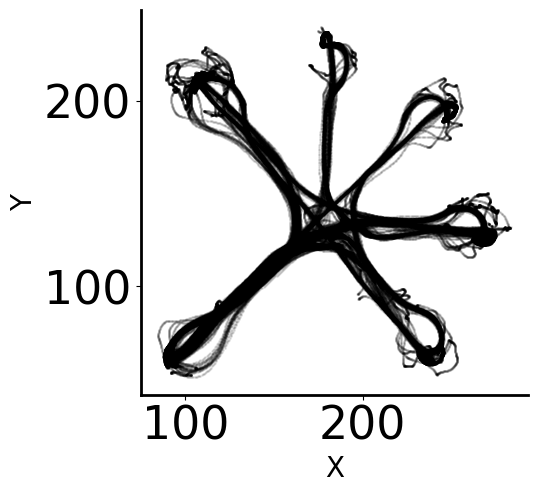

In [11]:


# Plot the pos data you will train on
if DECODE_DIMS == 1:
    plt.figure(figsize=(20, 5))
    plt.scatter(timestamps_train_up, pos_train_up, clip_on=False, s=1, color='black')
    plt.xlabel('Time')
    plt.ylabel('Linear Position')
    sns.despine()
elif DECODE_DIMS == 2:
    plt.figure(figsize=(5, 5))
    plt.scatter(pos_train_up[:,0], pos_train_up[:,1], clip_on=False, s=1, color='black',alpha=0.1)
    plt.xlabel('X')
    plt.ylabel('Y')
    sns.despine()

In [12]:
# convert pos to TsdFrame as decode feature
if DECODE_DIMS == 1:
    pos_train_up = nap.Tsd(t=timestamps_train_up, d=pos_train_up)
    pos_all_up = nap.Tsd(t=timestamps_up, d=pos_up) # for later plotting
elif DECODE_DIMS == 2:
    pos_train_up = nap.TsdFrame(t=timestamps_train_up, d=pos_train_up,columns=['x','y'])
    pos_all_up = nap.TsdFrame(t=timestamps_up, d=pos_up,columns=['x','y']) # for later plotting

In [13]:
# Import spikes Data as df and TsGroup
nwb_units_df = day_rec.get_spikes() # import

# Convert to pynapple TsGroup
units_tsg = nap.TsGroup({i_unit: nap.Ts(this_unit)
     for i_unit, this_unit in 
     zip(nwb_units_df.index.values, nwb_units_df.spike_times)},
                time_support=epoch_train)
units_tsg.set_info(nwb_units_df.iloc[:, :-1])

In [14]:
units_CA1_tsg = {i_unit: nap.Ts(this_unit)
     for i_unit, this_unit in 
     zip(nwb_units_df.index.values, nwb_units_df.spike_times)
     if 'CA1' in nwb_units_df.loc[i_unit, 'region']}
units_PFC_tsg = {i_unit: nap.Ts(this_unit)
     for i_unit, this_unit in 
     zip(nwb_units_df.index.values, nwb_units_df.spike_times)
     if 'PFC' in nwb_units_df.loc[i_unit, 'region']}

# units_sorted_tsg = nap.TsGroup({**units_CA1_tsg, **units_PFC_tsg},
#                                time_support=epoch_train)
units_sorted_tsg = nap.TsGroup({**units_CA1_tsg},
                               time_support=epoch_train)
# units_sorted_tsg = nap.TsGroup({**units_PFC_tsg},
#                                time_support=epoch_train)

units_CA1_tsg = nap.TsGroup(units_CA1_tsg, time_support=epoch_train)
is_CA1 = pd.Series([False] * nwb_units_df.shape[0], name='is_CA1')
is_CA1[0:len(units_CA1_tsg)] = True
units_PFC_tsg = nap.TsGroup(units_PFC_tsg, time_support=epoch_train)
is_PFC = pd.Series([False] * nwb_units_df.shape[0], name='is_PFC')
is_PFC[0:len(units_PFC_tsg)] = True

In [15]:
# remove units with low spikes and interneurons
units_sorted_tsg = units_sorted_tsg.getby_threshold('rate', MAX_FR, op = '<')
units_sorted_tsg = units_sorted_tsg.getby_threshold('rate', MIN_FR, op = '>')

In [16]:
# tuning curves aka place fields
if DECODE_DIMS == 1:
    tcurves = nap.compute_1d_tuning_curves(
        group=units_sorted_tsg,
        feature=pos_train_up,
        nb_bins=SPACE_BINS,
    )
elif DECODE_DIMS == 2:
    tcurves, binsxy = nap.compute_2d_tuning_curves(
    group=units_sorted_tsg,
    features=pos_train_up,
    nb_bins=SPACE_BINS,
)

c:\Users\BlakePorter\anaconda3\envs\SL_Analysis\Lib\site-packages\pynapple\process\tuning_curves.py:223: RuntimeWarning: invalid value encountered in divide
  count = count / occupancy


In [17]:
cell_IDs = list(tcurves.keys()) # cells parsed by brain region will have diff idx to their index

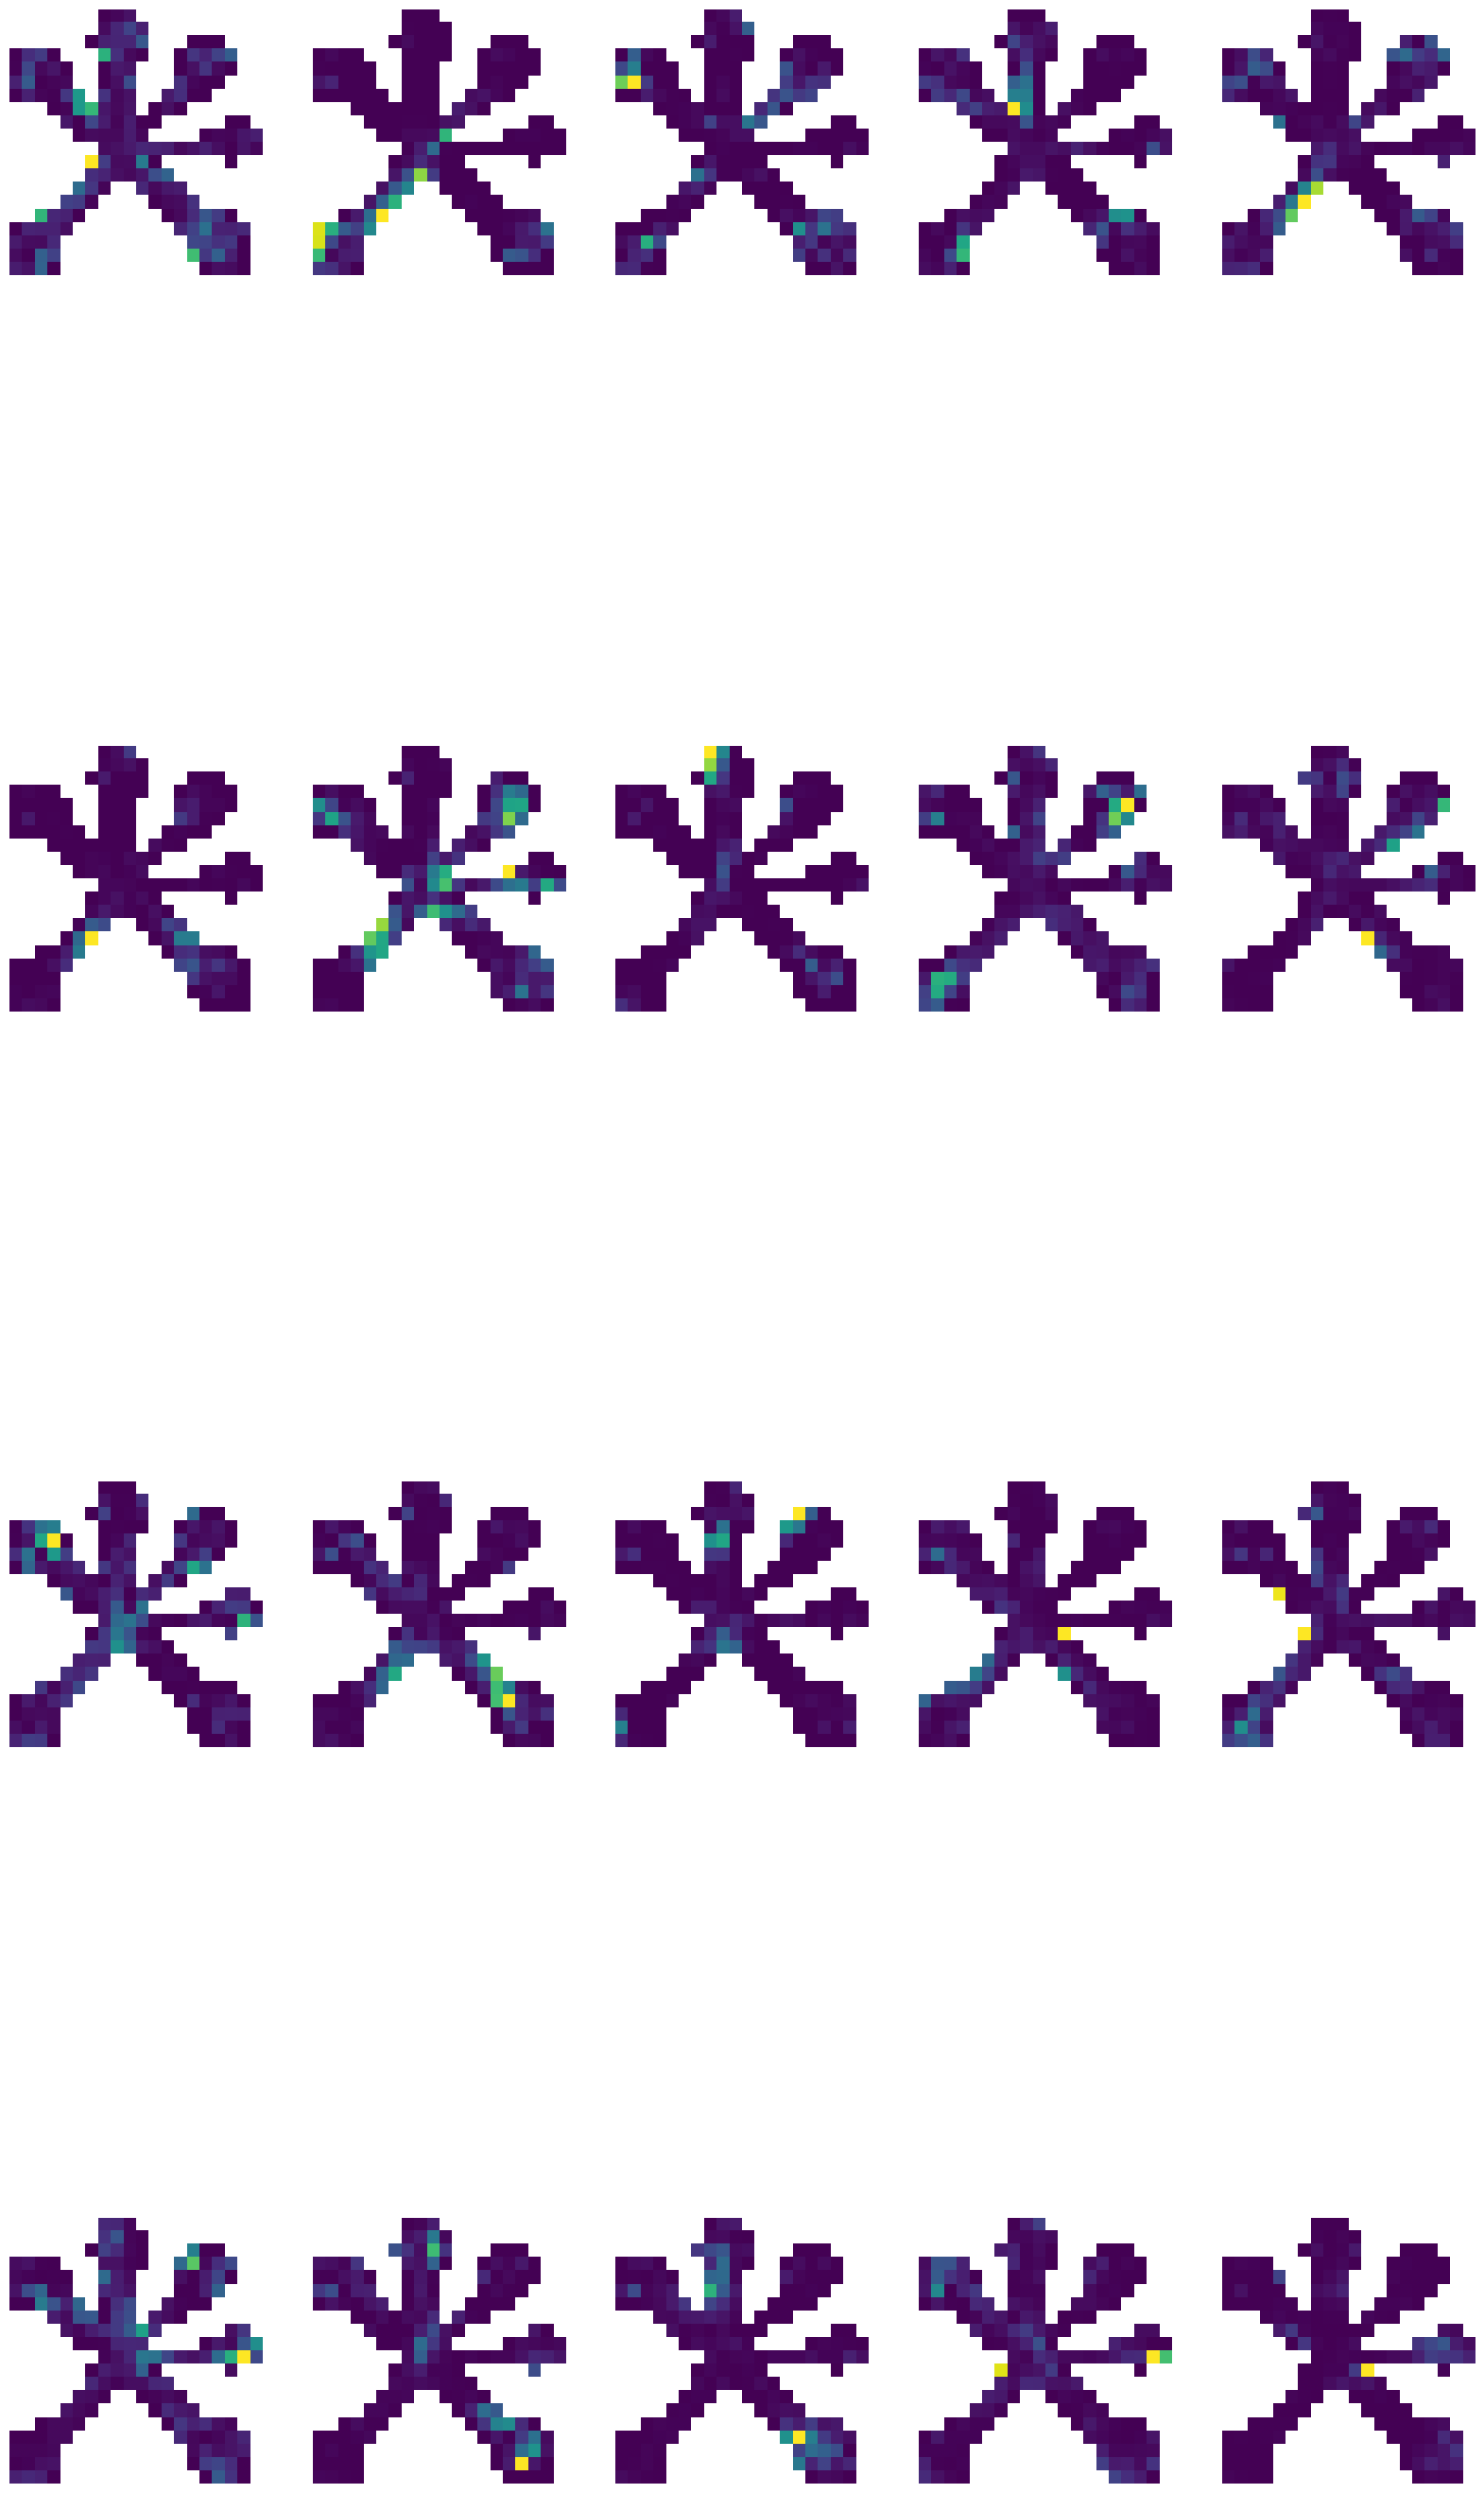

In [18]:
# plot tuning curves for all cells, aka place field maps
if DECODE_DIMS == 1:
    plt.figure(figsize=(20, 150))
    for i in range(len(cell_IDs)):
        cell_key = cell_IDs[i]
        plt.subplot(15, 5, i + 1)
        plt.plot(tcurves[cell_key])
        plt.xticks()
    plt.show()
elif DECODE_DIMS == 2:
    plt.figure(figsize=(20, 150))
    for i in range(len(cell_IDs)):
        cell_key = cell_IDs[i]
        plt.subplot(15, 5, i + 1)
        plt.imshow(
            tcurves[cell_key], extent=(binsxy[1][0], binsxy[1][-1], binsxy[0][0], binsxy[0][-1]),origin='lower'
        )
        # clear all ticks and labels
        plt.xticks([])
        plt.yticks([])
        plt.box(False)
    plt.show()

In [19]:
# End goal
# https://pynapple.org/reference/process/decoding/#pynapple.process.decoding.decode_2d


# 32sec
if DECODE_DIMS == 1:
    decode, prob = nap.decode_1d(
        tuning_curves = tcurves,
        group = units_sorted_tsg,
        ep = epoch_train,
        bin_size = BIN_SIZE,
        feature = pos_all_up,
)
elif DECODE_DIMS == 2:
    decode, prob = nap.decode_2d(
        tuning_curves = tcurves,
        group = units_sorted_tsg,
        ep = epoch_train,
        bin_size = BIN_SIZE,
        xy = binsxy,
        time_units = "s",
        features = pos_all_up,
)

In [20]:
# Create interval sets of interest for plotting
plot_epoch = nap.IntervalSet(start=[3050], end=[3200], time_units='s')

plot_pos_all_up = pos_all_up.restrict(plot_epoch)
plot_decode = decode.restrict(plot_epoch)

plot_pos_binCount = plot_pos_all_up.count().data()
plot_decode_binCount = plot_decode.count().data()

pos_colors = np.arange(1, plot_pos_binCount+1, 1)
decode_colors = np.arange(1, plot_decode_binCount+1, 1)


C:\Users\BlakePorter\AppData\Local\Temp\ipykernel_31388\3973194692.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_colors = np.arange(1, plot_pos_binCount+1, 1)
C:\Users\BlakePorter\AppData\Local\Temp\ipykernel_31388\3973194692.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  decode_colors = np.arange(1, plot_decode_binCount+1, 1)


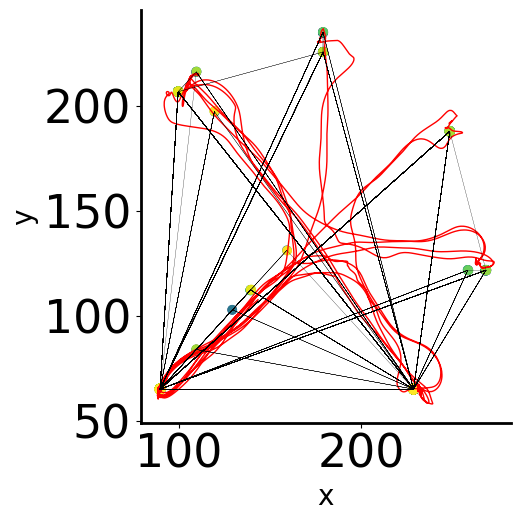

In [21]:
# Plot 2D decode
if DECODE_DIMS == 2:
    # on plot_decode i want to add some random noise to the data
    plot_decode_noisy = plot_decode.data() + np.random.normal(0, 0.1, plot_decode.data().shape)

    # convert plot_decode_noisy to TsdFrame
    plot_decode_noisy = nap.TsdFrame(t=plot_decode.index.values, d=plot_decode_noisy, columns=['x','y'])

    plt.figure(figsize=(6, 6))
    plt.plot(
        plot_pos_all_up["x"],
        plot_pos_all_up["y"],
        color='red',
        linewidth=1,
        label="True",
    )
    
    # plt.scatter(
    #     plot_pos_all_up["x"],
    #     plot_pos_all_up["y"],
    #     c = pos_colors,
    #     cmap='plasma',
    #     label="True",
    # )
    
    plt.scatter(
        plot_decode_noisy["x"],
        plot_decode_noisy["y"],
        c = decode_colors,
        cmap='viridis',
        label="Decoded",
    )
    
    plt.plot(plot_decode["x"],
            plot_decode["y"],
            color='black',
            linewidth=0.2,
    )
    
    plt.xlabel("x")
    plt.ylabel("y")
    #plt.legend()
    #plt.colorbar()
    plt.tight_layout()
    plt.show()

Average Error: 141.33923554905454
Average Error Run: 124.09693252830871


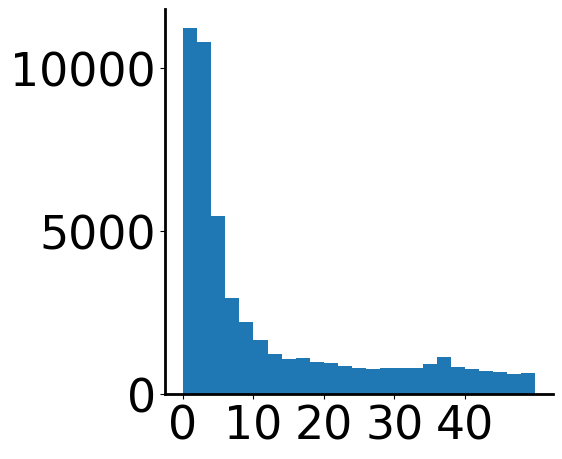

In [23]:
# I want to calcualte the error from the decode to the true pos
if DECODE_DIMS == 2:
    # first I need to convert deocde and pos_all_up to a nparrays
    decode_df = decode.as_dataframe()
    pos_all_up_df = pos_all_up.as_dataframe()

    # Ensure the index is sorted for searchsorted to work correctly
    pos_all_up_df = pos_all_up_df.sort_index()

    # Find the closest index in pos_all_up_df for each index in decode_df
    closest_indices = np.searchsorted(pos_all_up_df.index, decode_df.index)

    # Clip the indices to ensure they are within the valid range
    closest_indices = np.clip(closest_indices, 0, len(pos_all_up_df.index) - 1)

    # Align pos_all_up_df with decode_df using the closest indices
    aligned_pos_all_up_df = pos_all_up_df.iloc[closest_indices].set_index(decode_df.index)

    if DECODE_DIMS == 1:
        decode_error = np.sqrt((decode_df["x"] - aligned_pos_all_up_df["x"])**2) # NOT TESTED I THINK COL NAME IS WRONG
    elif DECODE_DIMS == 2:
        decode_error = np.sqrt((decode_df["x"] - aligned_pos_all_up_df["x"])**2 + (decode_df["y"] - aligned_pos_all_up_df["y"])**2)
        
    # average error
    avg_error = np.nanmedian(decode_error)
    print(f'Average Error: {avg_error}')

    # now use train_idx to delete values during stillness and nans from decode_error
    decode_error_run = np.delete(decode_error, train_idx)
    avg_error_run = np.median(decode_error_run)
    print(f'Average Error Run: {avg_error_run}')

    # plot a histogram of the run error with a bin width of 2 and a range from 0 to 50
    w = 2
    plt.figure(figsize=(5, 5))
    plt.hist(decode_error_run, bins=np.arange(min(decode_error_run), 50 + w, w))
    # add x tick labels at 0, 10, 20, 30, 40, 50
    plt.xticks(np.arange(0, 50, 10))
    
    # subtract the "x" column in from the two arrays to get the error, ignore the index
    decode_error = np.sqrt((decode_df["x"] - pos_all_up_df["x"])**2 + (decode_df["y"] - pos_all_up_df["y"])**2)


In [ ]:
# Loop through every run, defined from one well to the next well, and plot real and decoded position
# saves every graph

for i in range(len(traj_df)):
    start_time = traj_df['start_time'][i]
    end_time = traj_df['stop_time'][i]
    run_epoch = nap.IntervalSet(start=[start_time], end=[end_time], time_units='s')
    
    pos_run = pos_all_up.restrict(run_epoch)
    decode_run = decode.restrict(run_epoch)
    
    pos_run_binCount = pos_run.count().data()
    decode_run_binCount = decode_run.count().data()
    
    pos_colors = np.arange(1, pos_run_binCount+1, 1)
    decode_colors = np.arange(1, decode_run_binCount+1, 1)
    
    if DECODE_DIMS == 1:
        plt.figure(figsize=(20, 5))
        plt.plot(
            pos_run.index.values,
            pos_run.data(),
            color='red',
            linewidth=1,
            label="True",
        )
        
        plt.scatter(
            decode_run.index.values,
            decode_run.data(),
            c = decode_colors,
            cmap='plasma',
            label="Decoded",
        )
        
        plt.plot(
                decode_run.index.values,
                decode_run.data(),
                color='black',
                linewidth=0.2,
                alpha=1.0,
        )
        
        plt.xlabel("Time")
        plt.ylabel("Linear Position")
        #plt.legend()
        #plt.colorbar()
        plt.tight_layout()
        plt.savefig(os.path.join(paths["figure_path"], f"Bayes_1D_run_{i+1}.png"))
        plt.close()
    elif DECODE_DIMS == 2:
        plt.figure(figsize=(6, 6))
        plt.plot(
            pos_run["x"],
            pos_run["y"],
            color='red',
            linewidth=1,
            label="True",
        )
        
        plt.scatter(
            decode_run["x"],
            decode_run["y"],
            c = decode_colors,
            cmap='viridis',
            label="Decoded",
        )
        
        plt.plot(pos_all_up["x"],
                pos_all_up["y"],
                color='black',
                linewidth=0.2,
                alpha=0.1,
        )
        
        plt.xlabel("x")
        plt.ylabel("y")
        #plt.legend()
        #plt.colorbar()
        plt.tight_layout()
        plt.savefig(os.path.join(paths["figure_path"], f"Bayes_2D_run_{i+1}.png"))
        plt.close()  

In [ ]:
# Create interval sets of interest for plotting
plot_epoch = nap.IntervalSet(start=[3050], end=[3100], time_units='s')

plot_pos_all_up = pos_all_up.restrict(plot_epoch)
plot_decode = decode.restrict(plot_epoch)

plot_pos_binCount = plot_pos_all_up.count().data()
plot_decode_binCount = plot_decode.count().data()

pos_colors = np.arange(1, plot_pos_binCount+1, 1)
decode_colors = np.arange(1, plot_decode_binCount+1, 1)

In [ ]:
# Plot 1D decode
if DECODE_DIMS == 1:
    plt.figure(figsize=(20, 5))
    #plt.scatter(plot_pos_all_up.index.values, plot_pos_all_up.data(), color ='black', s=10)
    plt.plot(plot_pos_all_up.index.values, plot_pos_all_up.data(), color='red', linewidth=1)
    plt.scatter(plot_decode.index.values, plot_decode.data(), c=decode_colors, cmap='plasma', s=10)
    plt.xlabel('Time')
    
    plt.ylabel('Linear Position')
    sns.despine()

In [36]:
# 1D plotting porbability at each time

# Create a DataFrame with the lin pos and the probability of each bin
# there seems to be some sort of offset with the decoded position vs the real position which grows across arms
# home seems fine but guess worse further out
if DECODE_DIMS == 1:    
    plt.figure()
    plt.plot(
        plot_pos_all_up, "w", linewidth=2, label="real pos", zorder=1,alpha=0.2
    )  # Actual, in white
    # plt.plot(
    #     plot_decode, "--", color="grey", linewidth=2, label="decode pos", zorder=1
    # )  # Decoded, in grey

    # Plot the smoothed probability distribution
    plt.imshow(
        np.transpose(prob.restrict(plot_epoch).values),
        aspect="auto",
        #interpolation="bilinear",
        extent=[plot_epoch["start"][0], plot_epoch["end"][0], 0, plot_pos_all_up.max()],
        origin="lower",
        cmap="viridis",
    )

    plt.xlabel("Time (s)")  # X-axis is time in seconds
    plt.ylabel("Lin pos")  # Y-axis is the linear position
    plt.colorbar(label="probability")

In [ ]:
# try to work with probability matricies in prob
if DECODE_DIMS == 2:   
    # get out the first 20 rows of prob, each row is a time point and each matrix is the 2D data
    aa = prob[:20]

    # sum the probabilities of aa
    bb = np.sum(aa, axis=0)

    # plot bb with imshow
    plt.imshow(bb, cmap='viridis', origin='lower')

In [28]:
# okay let's recreate going through MUA events
# previously i binned at frame rate

MUA_units_sorted_tsg = nap.TsGroup({**units_CA1_tsg},
                               time_support=epoch_train)
MUA_units_this_epoch = MUA_units_sorted_tsg.restrict(epoch_train)

# use pynapple's .getby_threshold() to remove interneurons that will just add noise to the thresholding 
units_this_epoch_pyr = MUA_units_this_epoch.getby_threshold('rate', MAX_FR, op = '<')

# bin spike counts
binned_spikes_all = units_this_epoch_pyr.count(bin_size=MUA_BIN_SIZE, time_units='s',ep=epoch_train)
epoch_binned_times = binned_spikes_all.times()
# mean across all units and convery to np.array
binned_spikes_mean = binned_spikes_all.mean(axis=1).as_array()

# put a boxcar filter on the binned spikes
# SMOOTHED CURRENTLY NOT USED
# smoothing can have a massive impact on the results and should be used with caution. you likely want to recalculate the threshold after smoothing
binned_spikes_smooth = sp.ndimage.filters.gaussian_filter1d(binned_spikes_mean, 1)

# Make one graph with two plots of 1000 elements with one plotting binned_spikes and the second plotting binned_spikes_smooth
spike_threshold = binned_spikes_mean.mean() + (binned_spikes_mean.std()*MUA_SPK_SD_THRESHOLD)


C:\Users\BlakePorter\AppData\Local\Temp\ipykernel_31388\1388659399.py:20: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  binned_spikes_smooth = sp.ndimage.filters.gaussian_filter1d(binned_spikes_mean, 1)


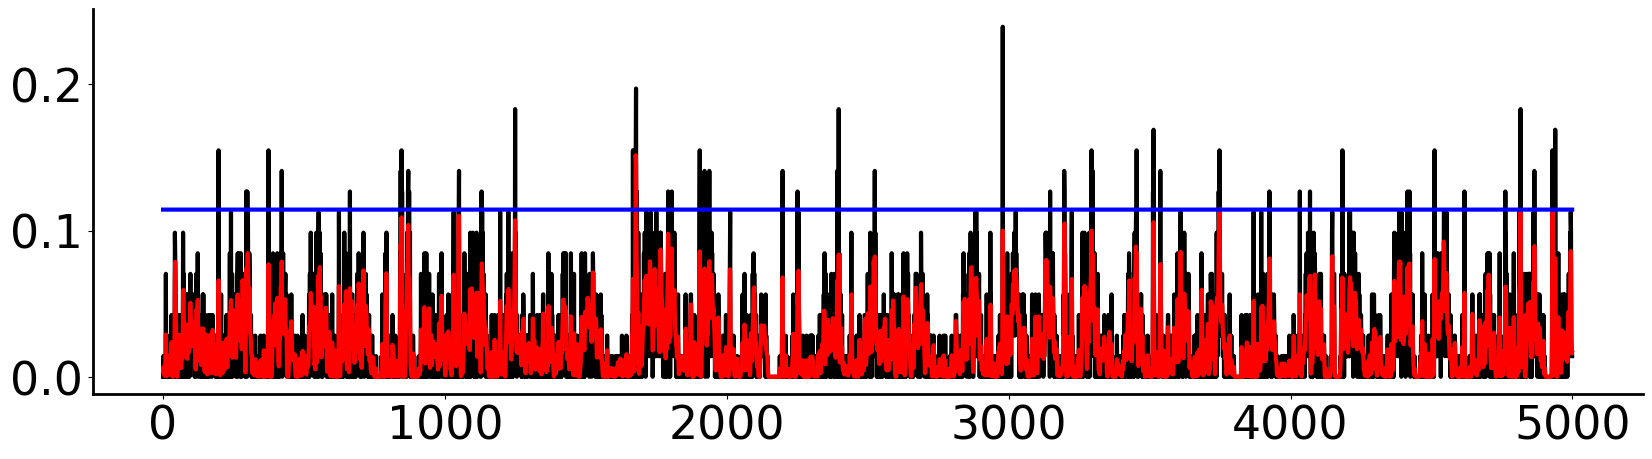

In [29]:
# plot spike SD threshold for a manual slice
SLICE_START = 5000
SLICE_END = 10000

plt.figure(figsize=(20, 5))
time_ind = slice(SLICE_START, SLICE_END)
plt.plot(binned_spikes_mean[time_ind], color='black')
plt.plot(binned_spikes_smooth[time_ind], color='red')
plt.plot(np.ones_like(binned_spikes_mean[time_ind]) * spike_threshold, color='blue')

In [30]:
# now with binned spiking activity, i want to find the indecies when the spike count goes over a certain threshold and then use that as the time of the events
# I will use a threshold based on the mean and std of the binned spikes
spike_threshold = binned_spikes_mean.mean() + (binned_spikes_mean.std()*MUA_SPK_SD_THRESHOLD)
MUA_events = np.where(binned_spikes_mean >= spike_threshold)
MUA_event_times = epoch_binned_times[MUA_events]

# MUA_event_times has times of events
# however, some of these events may be close together
# i want to go through MUA_event_times and treat them as the start time of an event
# the end time of an event will be MUA_BIN_SIZE seconds later 
# however, i want to concatenate events that occur within MUA_BIN_CONCAT of each other so that the end time is extended
# i will then use the start and end times to create a new epoch

MUA_event_diff = np.diff(MUA_event_times)
MUA_event_diff = np.insert(MUA_event_diff, 0, [0])
MUA_event_diff_bool = MUA_event_diff <= MUA_BIN_CONCAT

MUA_event_start_times = [MUA_event_times[0]]
MUA_event_end_times = []

# create a list of start and end times
for curr_pos in range(len(MUA_event_diff_bool)-1):
    if MUA_event_diff_bool[curr_pos] == False:
        MUA_event_start_times.append(MUA_event_times[curr_pos])
    if MUA_event_diff_bool[curr_pos] == True and MUA_event_diff_bool[curr_pos+1] == False:
        MUA_event_end_times.append(MUA_event_times[curr_pos])
    if MUA_event_diff_bool[curr_pos] == False and MUA_event_diff_bool[curr_pos+1] == False:
        MUA_event_end_times.append(MUA_event_times[curr_pos])
        
if MUA_event_diff_bool[-1] == True:
    MUA_event_end_times.append(MUA_event_times[-1])

# If the different between the start_times and end_times are 0, so 1 bin of high MUA, add MUA_BIN_SIZE to the end time to make it a duration the size of our bin
for i, (start, end) in enumerate(zip(MUA_event_start_times, MUA_event_end_times)):
    if end - start == 0:
        MUA_event_end_times[i] = start + MUA_BIN_SIZE

In [31]:
# Now we have MUA_event_start_times and MUA_event_end_times where spike counts are above threshold
# Now we need to check the velocity of the animal during these epochs and only keep the times where the animal is not moving
# track_df_epoch already has the velocity of the animal in vel col
# however, event_start and event_end times are binned and not the same values as the trag_df_train index, so find the closet index in track_df_epoch to the event_start and event_end times
# then check the velocity of the animal at those times
# if the velocity is below a certain threshold, keep the event, if not, discard it

MUA_event_vel = []
MUA_event_start_times_good = []
MUA_event_end_times_good = []

for start, end in zip(MUA_event_start_times, MUA_event_end_times):
    start_ind = np.abs(track_df_epoch.index - start).argmin()
    end_ind = np.abs(track_df_epoch.index - end).argmin()
    if track_df_epoch['vel'].iloc[start_ind:end_ind].mean() < VEL_THRESH:
        MUA_event_start_times_good.append(start)
        MUA_event_end_times_good.append(end)
        MUA_event_vel.append(track_df_epoch['vel'].iloc[start_ind:end_ind].mean())
        

# create a pandas dataframe with the start and end times of the MUA events as well as event_vel and duration
MUA_event_epochs_df = pd.DataFrame({'start_times': MUA_event_start_times_good, 'end_times': MUA_event_end_times_good, 'duration': np.array(MUA_event_end_times_good) - np.array(MUA_event_start_times_good), 'vel': MUA_event_vel})


In [32]:
# i want to go through all MUA_event_epochs_df and find where the time betweeen the end of one event and start of the next is smaller than a threshold
# if they are below this threshold, i want to combine the two events into one

MUA_event_starts = MUA_event_epochs_df['start_times'].values
MUA_event_ends = MUA_event_epochs_df['end_times'].values

# make list the size of MUA_event_starts full of 1's
# this will be used to keep track of which events are good
# if an event is combined with another event, the value at that index will be set to 0
# if the value is 0, the event will be removed from the MUA_event_epochs_df
MUA_event_starts_good = [1] * len(MUA_event_starts)
MUA_event_ends_good = [1] * len(MUA_event_starts)

for time in range(len(MUA_event_starts)-1):
    if MUA_event_starts[time+1] - MUA_event_ends[time] < MUA_BIN_CONCAT:
        MUA_event_ends[time] = MUA_event_ends[time+1]
        MUA_event_starts_good[time+1] = np.nan
        MUA_event_ends_good[time] = np.nan
        
MUA_event_starts = MUA_event_starts[~np.isnan(MUA_event_starts)]
MUA_event_ends = MUA_event_ends[~np.isnan(MUA_event_ends)]

# create a new MUA_event_epochs_df with the new start and end times
MUA_event_epochs_df = pd.DataFrame({'start_times': MUA_event_starts, 'end_times': MUA_event_ends, 'duration': np.array(MUA_event_ends) - np.array(MUA_event_starts)})


In [33]:
# Parse MUA events again based on spike times so that they start on the first spike time and end on the last spike time
# this should help tighten Eric's decoder
MUA_event_spike_start_times = []
MUA_event_spike_end_times = []

# initialize a boolean list to keep track of which events are good
MUA_event_good = [False] * len(MUA_event_start_times_good)

# use MUA_event_epochs_df and go through each row in start_times and end_times and find the closest spike time to the start and end times using spike_times_all_list
# then create a new dataframe of the start and end times of the MUA events based on the spike times
idx_count = 0
for start, end in zip(MUA_event_start_times_good, MUA_event_end_times_good):
    # create an nap.IntervalSet with the start and end times
    event_interval = nap.IntervalSet(start, end)
    # restrict the spike times to the event_interval
    event_spike_times = units_this_epoch_pyr.restrict(event_interval).to_tsd().times()
    
    # if event_spike_times is empty, then the event is not good
    if len(event_spike_times) < MUA_MIN_SPIKES:
        continue
    else:
        MUA_event_spike_start_times.append(event_spike_times[0])
        MUA_event_spike_end_times.append(event_spike_times[-1])
        MUA_event_good[idx_count] = True # set to true i dont know how to index
        
    idx_count += 1
    
# drop rows on MUA_event_epochs_df that are not good based on MUA_event_good
MUA_event_epochs_df = MUA_event_epochs_df[MUA_event_good]

# replace start_times and end_times in MUA_event_epochs_df with MUA_event_spike_start_times and MUA_event_spike_end_times
MUA_event_epochs_df['start_times'] = MUA_event_spike_start_times
MUA_event_epochs_df['end_times'] = MUA_event_spike_end_times
    

Text(0.5, 1.0, 'MUA events on track')

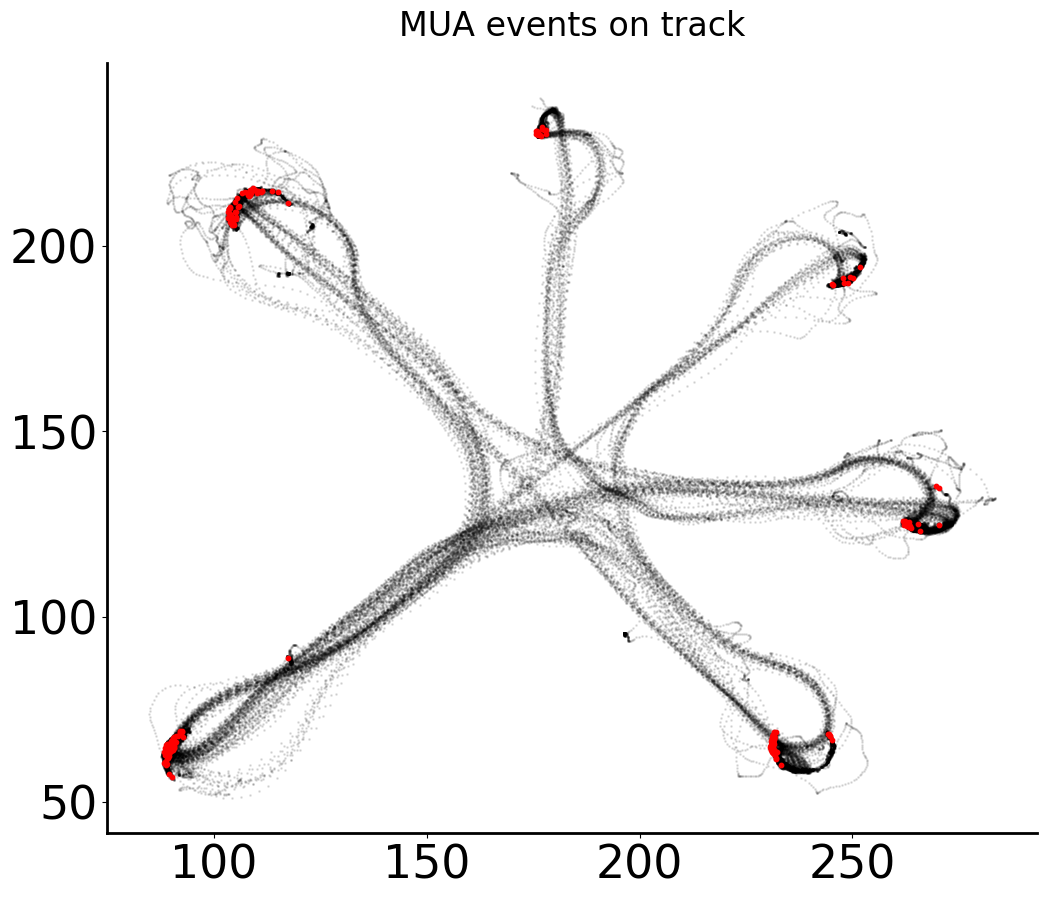

In [34]:
# Use the start times from MUA_event_epochs_df to index to the x and y positions of the animal in the traf_df_epoch
start_ind = [np.abs(track_df_epoch.index - start).argmin() for start in MUA_event_epochs_df['start_times']]

MUA_event_epochs_df['x_start'] = track_df_epoch['x'].iloc[start_ind].values
MUA_event_epochs_df['y_start'] = track_df_epoch['y'].iloc[start_ind].values

# now use the x_start and y_start to plot every event on the track overlaid by the animal's x and y position from traf_df_epoch
plt.figure(figsize=(12, 10))
plt.scatter(track_df_epoch['x'],track_df_epoch['y'],s=1,color='black',alpha=0.1)
plt.scatter(MUA_event_epochs_df['x_start'], MUA_event_epochs_df['y_start'], color='red', s=10)
plt.title('MUA events on track')

# Okay these look to be working and mainly getting events at reward wells

In [ ]:
# Create interval sets of interest for plotting
plot_epoch = nap.IntervalSet(start=[3050], end=[3100], time_units='s')

plot_pos_all_up = pos_all_up.restrict(plot_epoch)
plot_decode = decode.restrict(plot_epoch)

plot_pos_binCount = plot_pos_all_up.count().data()
plot_decode_binCount = plot_decode.count().data()

pos_colors = np.arange(1, plot_pos_binCount+1, 1)
decode_colors = np.arange(1, plot_decode_binCount+1, 1)

In [35]:
# 2D MUA event replay events
# loop through all the MUA events stored in MUA_event_epochs_df and plot the x and y position of the animal during the event
# and the decoded position of the animal during the event

    


NameError: name 'decoder' is not defined